### Cab-Driver Agent

In [3]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print("\nData shape:\n", np.shape(Time_matrix))
print("dimensions = ",len(Time_matrix.shape))


Data shape:
 (5, 5, 24, 7)
dimensions =  4


In [5]:
 # Call the environment
env = CabDriver()

#### Tracking the state-action pairs for checking convergence


In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [101]:
class DQNAgent:
    def __init__(self, state_size, action_size,learning_rate):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        #Below are important hyper params and various values tried with final values uncommented
        #self.discount_factor =0.9
        self.discount_factor =0.95

        #self.learning_rate =0.001
        #self.learning_rate = 0.01
        self.learning_rate = learning_rate

        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay =  .995
        #self.epsilon_decay = -0.0005
        #self.epsilon_decay =  .999
        self.epsilon_decay = 0.0005
        #self.epsilon_min = 0.001
        #self.epsilon_min = 0.00001
        self.epsilon_min = 0.01


        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model


    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            return random.sample(possible_actions_index,1)[0]
        else:
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]    

    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
                # Write your code from here
                
            # 1. Predict the target from earlier model           
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    def save_tracking_states(self):
        # Predicting q_value of the state tracked.
        q_value = self.model.predict(self.track_state)
        
        # retaining q_value of the action tracked.
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)

In [102]:
Episodes = 8000

### DQN block

In [103]:
#Testing with Episodes 8000
learning_rate = 0.01
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [2, 1, 3]
episode 0, reward -212.0, memory_length 120, epsilon 0.0005, time 729.0, rides 119
Initial State is  [2, 1, 3]
episode 1, reward -206.0, memory_length 247, epsilon 0.0005, time 729.0, rides 126
Initial State is  [2, 1, 3]
episode 2, reward 82.0, memory_length 380, epsilon 0.0005, time 741.0, rides 132
Initial State is  [2, 1, 3]
episode 3, reward 122.0, memory_length 509, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 4, reward 404.0, memory_length 640, epsilon 0.0005, time 731.0, rides 130
Initial State is  [2, 1, 3]
episode 5, reward 232.0, memory_length 775, epsilon 0.0005, time 729.0, rides 134
Initial State is  [2, 1, 3]
episode 6, reward 215.0, memory_length 916, epsilon 0.0005, time 730.0, rides 140
Initial State is  [2, 1, 3]
episode 7, reward 202.0, memory_length 1035, epsilon 0.0005, time 725.0, rides 118
Initial State is  [2, 1, 3]
episode 8, reward 137.0, memory_length 1157, epsilon 0.0005, time 729.0, rides 121
Initial

episode 74, reward 799.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 143
Initial State is  [2, 1, 3]
episode 75, reward 534.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 141
Initial State is  [2, 1, 3]
episode 76, reward 808.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 148
Initial State is  [2, 1, 3]
episode 77, reward 407.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 141
Initial State is  [2, 1, 3]
episode 78, reward 750.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 123
Initial State is  [2, 1, 3]
episode 79, reward 455.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 142
Initial State is  [2, 1, 3]
episode 80, reward 514.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 142
Initial State is  [2, 1, 3]
episode 81, reward 704.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 139
Initial State is  [2, 1, 3]
episode 82, reward 872.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 125
Initial State is  [2

episode 147, reward 549.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
Initial State is  [2, 1, 3]
episode 148, reward 574.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 138
Initial State is  [2, 1, 3]
episode 149, reward 658.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 126
Initial State is  [2, 1, 3]
episode 150, reward 677.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 142
Initial State is  [2, 1, 3]
episode 151, reward 581.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 140
Initial State is  [2, 1, 3]
episode 152, reward 585.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 157
Initial State is  [2, 1, 3]
episode 153, reward 789.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [2, 1, 3]
episode 154, reward 575.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [2, 1, 3]
episode 155, reward 685.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 159
Initial Sta

episode 220, reward 335.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [2, 1, 3]
episode 221, reward 750.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 147
Initial State is  [2, 1, 3]
episode 222, reward 465.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 128
Initial State is  [2, 1, 3]
episode 223, reward 601.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [2, 1, 3]
episode 224, reward 770.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 133
Initial State is  [2, 1, 3]
episode 225, reward 811.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 134
Initial State is  [2, 1, 3]
episode 226, reward 447.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 140
Initial State is  [2, 1, 3]
episode 227, reward 353.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 120
Initial State is  [2, 1, 3]
episode 228, reward 851.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial Sta

episode 293, reward 713.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [2, 1, 3]
episode 294, reward 771.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 141
Initial State is  [2, 1, 3]
episode 295, reward 507.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [2, 1, 3]
episode 296, reward 673.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 146
Initial State is  [2, 1, 3]
episode 297, reward 645.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 155
Initial State is  [2, 1, 3]
episode 298, reward 357.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 137
Initial State is  [2, 1, 3]
episode 299, reward 866.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 143
Initial State is  [2, 1, 3]
episode 300, reward 658.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [2, 1, 3]
episode 301, reward 449.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 134
Initial Sta

episode 366, reward 666.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 142
Initial State is  [2, 1, 3]
episode 367, reward 674.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [2, 1, 3]
episode 368, reward 884.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 369, reward 753.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 138
Initial State is  [2, 1, 3]
episode 370, reward 327.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [2, 1, 3]
episode 371, reward 721.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [2, 1, 3]
episode 372, reward 434.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 145
Initial State is  [2, 1, 3]
episode 373, reward 608.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [2, 1, 3]
episode 374, reward 818.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial Sta

episode 439, reward 473.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [2, 1, 3]
episode 440, reward 429.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [2, 1, 3]
episode 441, reward 545.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 143
Initial State is  [2, 1, 3]
episode 442, reward 628.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 141
Initial State is  [2, 1, 3]
episode 443, reward 224.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 140
Initial State is  [2, 1, 3]
episode 444, reward 499.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 148
Initial State is  [2, 1, 3]
episode 445, reward 537.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 123
Initial State is  [2, 1, 3]
episode 446, reward 613.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [2, 1, 3]
episode 447, reward 621.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 117
Initial Sta

episode 512, reward 507.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 140
Initial State is  [2, 1, 3]
episode 513, reward 890.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 151
Initial State is  [2, 1, 3]
episode 514, reward 573.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 141
Initial State is  [2, 1, 3]
episode 515, reward 598.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 145
Initial State is  [2, 1, 3]
episode 516, reward 381.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 141
Initial State is  [2, 1, 3]
episode 517, reward 382.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 138
Initial State is  [2, 1, 3]
episode 518, reward 587.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 147
Initial State is  [2, 1, 3]
episode 519, reward 584.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 144
Initial State is  [2, 1, 3]
episode 520, reward 588.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 139
Initial Sta

episode 585, reward 819.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 143
Initial State is  [2, 1, 3]
episode 586, reward 648.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 138
Initial State is  [2, 1, 3]
episode 587, reward 586.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [2, 1, 3]
episode 588, reward 576.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 589, reward 751.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 144
Initial State is  [2, 1, 3]
episode 590, reward 638.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 152
Initial State is  [2, 1, 3]
episode 591, reward 439.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 145
Initial State is  [2, 1, 3]
episode 592, reward 624.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [2, 1, 3]
episode 593, reward 532.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 133
Initial Sta

episode 658, reward 621.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 146
Initial State is  [2, 1, 3]
episode 659, reward 491.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 151
Initial State is  [2, 1, 3]
episode 660, reward 497.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 132
Initial State is  [2, 1, 3]
episode 661, reward 697.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 136
Initial State is  [2, 1, 3]
episode 662, reward 501.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 141
Initial State is  [2, 1, 3]
episode 663, reward 538.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
Initial State is  [2, 1, 3]
episode 664, reward 696.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [2, 1, 3]
episode 665, reward 857.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [2, 1, 3]
episode 666, reward 409.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 127
Initial Sta

episode 731, reward 712.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 145
Initial State is  [2, 1, 3]
episode 732, reward 631.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
Initial State is  [2, 1, 3]
episode 733, reward 657.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 153
Initial State is  [2, 1, 3]
episode 734, reward 794.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 151
Initial State is  [2, 1, 3]
episode 735, reward 704.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [2, 1, 3]
episode 736, reward 808.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 149
Initial State is  [2, 1, 3]
episode 737, reward 703.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 158
Initial State is  [2, 1, 3]
episode 738, reward 499.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 154
Initial State is  [2, 1, 3]
episode 739, reward 396.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137
Initial Sta

episode 804, reward 715.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 139
Initial State is  [2, 1, 3]
episode 805, reward 619.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [2, 1, 3]
episode 806, reward 542.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [2, 1, 3]
episode 807, reward 595.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [2, 1, 3]
episode 808, reward 710.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 140
Initial State is  [2, 1, 3]
episode 809, reward 515.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 117
Initial State is  [2, 1, 3]
episode 810, reward 839.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 139
Initial State is  [2, 1, 3]
episode 811, reward 821.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 142
Initial State is  [2, 1, 3]
episode 812, reward 502.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial Sta

episode 877, reward 655.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [2, 1, 3]
episode 878, reward 693.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 137
Initial State is  [2, 1, 3]
episode 879, reward 935.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 138
Initial State is  [2, 1, 3]
episode 880, reward 739.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 143
Initial State is  [2, 1, 3]
episode 881, reward 836.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 140
Initial State is  [2, 1, 3]
episode 882, reward 637.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 151
Initial State is  [2, 1, 3]
episode 883, reward 689.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 131
Initial State is  [2, 1, 3]
episode 884, reward 641.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 141
Initial State is  [2, 1, 3]
episode 885, reward 720.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial Sta

episode 950, reward 696.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 141
Initial State is  [2, 1, 3]
episode 951, reward 709.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 127
Initial State is  [2, 1, 3]
episode 952, reward 766.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 136
Initial State is  [2, 1, 3]
episode 953, reward 599.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 141
Initial State is  [2, 1, 3]
episode 954, reward 665.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 135
Initial State is  [2, 1, 3]
episode 955, reward 625.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 146
Initial State is  [2, 1, 3]
episode 956, reward 549.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 139
Initial State is  [2, 1, 3]
episode 957, reward 755.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [2, 1, 3]
episode 958, reward 815.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial Sta

episode 1023, reward 607.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
Initial State is  [2, 1, 3]
episode 1024, reward 637.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 130
Initial State is  [2, 1, 3]
episode 1025, reward 511.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 130
Initial State is  [2, 1, 3]
episode 1026, reward 586.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 129
Initial State is  [2, 1, 3]
episode 1027, reward 498.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 127
Initial State is  [2, 1, 3]
episode 1028, reward 562.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [2, 1, 3]
episode 1029, reward 475.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [2, 1, 3]
episode 1030, reward 717.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 139
Initial State is  [2, 1, 3]
episode 1031, reward 747.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
In

episode 1095, reward 761.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136
Initial State is  [2, 1, 3]
episode 1096, reward 676.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [2, 1, 3]
episode 1097, reward 415.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [2, 1, 3]
episode 1098, reward 538.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 138
Initial State is  [2, 1, 3]
episode 1099, reward 464.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 146
Initial State is  [2, 1, 3]
episode 1100, reward 453.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [2, 1, 3]
episode 1101, reward 922.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 147
Initial State is  [2, 1, 3]
episode 1102, reward 365.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 1103, reward 706.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 145
In

episode 1167, reward 661.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 151
Initial State is  [2, 1, 3]
episode 1168, reward 622.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 143
Initial State is  [2, 1, 3]
episode 1169, reward 811.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 136
Initial State is  [2, 1, 3]
episode 1170, reward 485.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 142
Initial State is  [2, 1, 3]
episode 1171, reward 694.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137
Initial State is  [2, 1, 3]
episode 1172, reward 655.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 142
Initial State is  [2, 1, 3]
episode 1173, reward 419.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 157
Initial State is  [2, 1, 3]
episode 1174, reward 549.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 139
Initial State is  [2, 1, 3]
episode 1175, reward 553.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 142
In

episode 1239, reward 654.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [2, 1, 3]
episode 1240, reward 636.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 140
Initial State is  [2, 1, 3]
episode 1241, reward 565.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 137
Initial State is  [2, 1, 3]
episode 1242, reward 676.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 1243, reward 881.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 140
Initial State is  [2, 1, 3]
episode 1244, reward 682.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 134
Initial State is  [2, 1, 3]
episode 1245, reward 832.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [2, 1, 3]
episode 1246, reward 887.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 140
Initial State is  [2, 1, 3]
episode 1247, reward 498.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
In

episode 1311, reward 884.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 1312, reward 740.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 136
Initial State is  [2, 1, 3]
episode 1313, reward 637.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 132
Initial State is  [2, 1, 3]
episode 1314, reward 552.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136
Initial State is  [2, 1, 3]
episode 1315, reward 736.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [2, 1, 3]
episode 1316, reward 641.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 145
Initial State is  [2, 1, 3]
episode 1317, reward 642.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [2, 1, 3]
episode 1318, reward 764.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 147
Initial State is  [2, 1, 3]
episode 1319, reward 509.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 125
In

episode 1383, reward 961.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 150
Initial State is  [2, 1, 3]
episode 1384, reward 793.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 140
Initial State is  [2, 1, 3]
episode 1385, reward 346.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 124
Initial State is  [2, 1, 3]
episode 1386, reward 813.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 133
Initial State is  [2, 1, 3]
episode 1387, reward 633.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 135
Initial State is  [2, 1, 3]
episode 1388, reward 687.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 144
Initial State is  [2, 1, 3]
episode 1389, reward 792.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 153
Initial State is  [2, 1, 3]
episode 1390, reward 369.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 138
Initial State is  [2, 1, 3]
episode 1391, reward 621.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 136
In

episode 1455, reward 821.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 134
Initial State is  [2, 1, 3]
episode 1456, reward 835.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136
Initial State is  [2, 1, 3]
episode 1457, reward 549.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 134
Initial State is  [2, 1, 3]
episode 1458, reward 315.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 143
Initial State is  [2, 1, 3]
episode 1459, reward 712.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 139
Initial State is  [2, 1, 3]
episode 1460, reward 703.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 131
Initial State is  [2, 1, 3]
episode 1461, reward 723.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 136
Initial State is  [2, 1, 3]
episode 1462, reward 620.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 130
Initial State is  [2, 1, 3]
episode 1463, reward 789.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 148
In

episode 1527, reward 668.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 138
Initial State is  [2, 1, 3]
episode 1528, reward 738.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 147
Initial State is  [2, 1, 3]
episode 1529, reward 543.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [2, 1, 3]
episode 1530, reward 749.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [2, 1, 3]
episode 1531, reward 693.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 138
Initial State is  [2, 1, 3]
episode 1532, reward 757.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 139
Initial State is  [2, 1, 3]
episode 1533, reward 642.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 133
Initial State is  [2, 1, 3]
episode 1534, reward 545.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 143
Initial State is  [2, 1, 3]
episode 1535, reward 655.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 160
In

episode 1599, reward 1029.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 139
Initial State is  [2, 1, 3]
episode 1600, reward 548.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [2, 1, 3]
episode 1601, reward 499.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [2, 1, 3]
episode 1602, reward 895.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 148
Initial State is  [2, 1, 3]
episode 1603, reward 617.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 153
Initial State is  [2, 1, 3]
episode 1604, reward 597.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 150
Initial State is  [2, 1, 3]
episode 1605, reward 711.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 1606, reward 738.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 138
Initial State is  [2, 1, 3]
episode 1607, reward 538.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 160
I

episode 1671, reward 697.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 148
Initial State is  [2, 1, 3]
episode 1672, reward 642.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 147
Initial State is  [2, 1, 3]
episode 1673, reward 946.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 144
Initial State is  [2, 1, 3]
episode 1674, reward 604.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 143
Initial State is  [2, 1, 3]
episode 1675, reward 902.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [2, 1, 3]
episode 1676, reward 420.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 140
Initial State is  [2, 1, 3]
episode 1677, reward 683.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [2, 1, 3]
episode 1678, reward 825.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 139
Initial State is  [2, 1, 3]
episode 1679, reward 593.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
In

episode 1743, reward 796.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 129
Initial State is  [2, 1, 3]
episode 1744, reward 456.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [2, 1, 3]
episode 1745, reward 517.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [2, 1, 3]
episode 1746, reward 542.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 131
Initial State is  [2, 1, 3]
episode 1747, reward 530.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 121
Initial State is  [2, 1, 3]
episode 1748, reward 953.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 142
Initial State is  [2, 1, 3]
episode 1749, reward 996.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 145
Initial State is  [2, 1, 3]
episode 1750, reward 812.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 137
Initial State is  [2, 1, 3]
episode 1751, reward 611.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 140
In

episode 1815, reward 866.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 142
Initial State is  [2, 1, 3]
episode 1816, reward 791.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 149
Initial State is  [2, 1, 3]
episode 1817, reward 601.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 122
Initial State is  [2, 1, 3]
episode 1818, reward 559.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
Initial State is  [2, 1, 3]
episode 1819, reward 563.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 136
Initial State is  [2, 1, 3]
episode 1820, reward 871.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 133
Initial State is  [2, 1, 3]
episode 1821, reward 533.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 151
Initial State is  [2, 1, 3]
episode 1822, reward 675.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 145
Initial State is  [2, 1, 3]
episode 1823, reward 430.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 138
In

episode 1887, reward 181.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 129
Initial State is  [2, 1, 3]
episode 1888, reward 820.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [2, 1, 3]
episode 1889, reward 535.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 148
Initial State is  [2, 1, 3]
episode 1890, reward 519.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 156
Initial State is  [2, 1, 3]
episode 1891, reward 679.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 142
Initial State is  [2, 1, 3]
episode 1892, reward 620.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 141
Initial State is  [2, 1, 3]
episode 1893, reward 840.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 138
Initial State is  [2, 1, 3]
episode 1894, reward 578.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 150
Initial State is  [2, 1, 3]
episode 1895, reward 742.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 129
In

episode 1959, reward 386.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 126
Initial State is  [2, 1, 3]
episode 1960, reward 757.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 143
Initial State is  [2, 1, 3]
episode 1961, reward 785.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 140
Initial State is  [2, 1, 3]
episode 1962, reward 455.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 147
Initial State is  [2, 1, 3]
episode 1963, reward 740.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 142
Initial State is  [2, 1, 3]
episode 1964, reward 746.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 146
Initial State is  [2, 1, 3]
episode 1965, reward 620.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [2, 1, 3]
episode 1966, reward 570.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 129
Initial State is  [2, 1, 3]
episode 1967, reward 678.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 141
In

episode 2031, reward 708.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [2, 1, 3]
episode 2032, reward 785.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 140
Initial State is  [2, 1, 3]
episode 2033, reward 704.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 134
Initial State is  [2, 1, 3]
episode 2034, reward 364.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129
Initial State is  [2, 1, 3]
episode 2035, reward 692.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 2036, reward 842.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 126
Initial State is  [2, 1, 3]
episode 2037, reward 569.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [2, 1, 3]
episode 2038, reward 573.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 2039, reward 855.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 141
In

episode 2103, reward 884.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [2, 1, 3]
episode 2104, reward 853.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 142
Initial State is  [2, 1, 3]
episode 2105, reward 567.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 148
Initial State is  [2, 1, 3]
episode 2106, reward 460.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 138
Initial State is  [2, 1, 3]
episode 2107, reward 753.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 138
Initial State is  [2, 1, 3]
episode 2108, reward 614.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 137
Initial State is  [2, 1, 3]
episode 2109, reward 741.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 143
Initial State is  [2, 1, 3]
episode 2110, reward 483.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [2, 1, 3]
episode 2111, reward 584.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 147
In

episode 2175, reward 790.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 145
Initial State is  [2, 1, 3]
episode 2176, reward 648.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 135
Initial State is  [2, 1, 3]
episode 2177, reward 523.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 2178, reward 554.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 134
Initial State is  [2, 1, 3]
episode 2179, reward 641.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 140
Initial State is  [2, 1, 3]
episode 2180, reward 674.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 138
Initial State is  [2, 1, 3]
episode 2181, reward 733.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 146
Initial State is  [2, 1, 3]
episode 2182, reward 530.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 141
Initial State is  [2, 1, 3]
episode 2183, reward 586.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 142
In

episode 2247, reward 778.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [2, 1, 3]
episode 2248, reward 596.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 150
Initial State is  [2, 1, 3]
episode 2249, reward 552.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 147
Initial State is  [2, 1, 3]
episode 2250, reward 519.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 144
Initial State is  [2, 1, 3]
episode 2251, reward 652.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 140
Initial State is  [2, 1, 3]
episode 2252, reward 562.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 153
Initial State is  [2, 1, 3]
episode 2253, reward 659.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [2, 1, 3]
episode 2254, reward 633.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [2, 1, 3]
episode 2255, reward 610.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
In

episode 2319, reward 606.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131
Initial State is  [2, 1, 3]
episode 2320, reward 659.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 134
Initial State is  [2, 1, 3]
episode 2321, reward 886.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 2322, reward 559.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 144
Initial State is  [2, 1, 3]
episode 2323, reward 944.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 141
Initial State is  [2, 1, 3]
episode 2324, reward 1019.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 146
Initial State is  [2, 1, 3]
episode 2325, reward 816.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 140
Initial State is  [2, 1, 3]
episode 2326, reward 738.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 141
Initial State is  [2, 1, 3]
episode 2327, reward 720.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 141
I

episode 2391, reward 547.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 131
Initial State is  [2, 1, 3]
episode 2392, reward 581.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 2393, reward 693.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 139
Initial State is  [2, 1, 3]
episode 2394, reward 930.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 143
Initial State is  [2, 1, 3]
episode 2395, reward 647.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 145
Initial State is  [2, 1, 3]
episode 2396, reward 970.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 2397, reward 529.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [2, 1, 3]
episode 2398, reward 912.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 134
Initial State is  [2, 1, 3]
episode 2399, reward 843.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136
In

episode 2463, reward 727.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 138
Initial State is  [2, 1, 3]
episode 2464, reward 761.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 142
Initial State is  [2, 1, 3]
episode 2465, reward 443.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 145
Initial State is  [2, 1, 3]
episode 2466, reward 991.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 146
Initial State is  [2, 1, 3]
episode 2467, reward 666.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 147
Initial State is  [2, 1, 3]
episode 2468, reward 845.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 142
Initial State is  [2, 1, 3]
episode 2469, reward 684.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 139
Initial State is  [2, 1, 3]
episode 2470, reward 584.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 137
Initial State is  [2, 1, 3]
episode 2471, reward 842.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 132
In

episode 2535, reward 245.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [2, 1, 3]
episode 2536, reward 828.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [2, 1, 3]
episode 2537, reward 614.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 140
Initial State is  [2, 1, 3]
episode 2538, reward 829.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 140
Initial State is  [2, 1, 3]
episode 2539, reward 737.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 139
Initial State is  [2, 1, 3]
episode 2540, reward 748.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 136
Initial State is  [2, 1, 3]
episode 2541, reward 761.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 155
Initial State is  [2, 1, 3]
episode 2542, reward 446.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131
Initial State is  [2, 1, 3]
episode 2543, reward 875.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
In

episode 2607, reward 580.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 142
Initial State is  [2, 1, 3]
episode 2608, reward 779.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [2, 1, 3]
episode 2609, reward 758.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [2, 1, 3]
episode 2610, reward 744.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 139
Initial State is  [2, 1, 3]
episode 2611, reward 405.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 146
Initial State is  [2, 1, 3]
episode 2612, reward 765.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 141
Initial State is  [2, 1, 3]
episode 2613, reward 540.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 146
Initial State is  [2, 1, 3]
episode 2614, reward 654.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
Initial State is  [2, 1, 3]
episode 2615, reward 912.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 135
In

episode 2679, reward 707.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 128
Initial State is  [2, 1, 3]
episode 2680, reward 673.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 139
Initial State is  [2, 1, 3]
episode 2681, reward 750.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 141
Initial State is  [2, 1, 3]
episode 2682, reward 547.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 144
Initial State is  [2, 1, 3]
episode 2683, reward 611.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 140
Initial State is  [2, 1, 3]
episode 2684, reward 702.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 139
Initial State is  [2, 1, 3]
episode 2685, reward 621.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [2, 1, 3]
episode 2686, reward 708.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 144
Initial State is  [2, 1, 3]
episode 2687, reward 884.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
In

episode 2751, reward 874.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 139
Initial State is  [2, 1, 3]
episode 2752, reward 466.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 142
Initial State is  [2, 1, 3]
episode 2753, reward 761.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 146
Initial State is  [2, 1, 3]
episode 2754, reward 885.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 148
Initial State is  [2, 1, 3]
episode 2755, reward 634.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 148
Initial State is  [2, 1, 3]
episode 2756, reward 608.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 2757, reward 943.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 148
Initial State is  [2, 1, 3]
episode 2758, reward 612.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 138
Initial State is  [2, 1, 3]
episode 2759, reward 516.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 134
In

episode 2823, reward 717.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 144
Initial State is  [2, 1, 3]
episode 2824, reward 975.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 140
Initial State is  [2, 1, 3]
episode 2825, reward 696.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 134
Initial State is  [2, 1, 3]
episode 2826, reward 354.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 142
Initial State is  [2, 1, 3]
episode 2827, reward 626.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 137
Initial State is  [2, 1, 3]
episode 2828, reward 646.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 2829, reward 724.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 159
Initial State is  [2, 1, 3]
episode 2830, reward 655.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 133
Initial State is  [2, 1, 3]
episode 2831, reward 459.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 119
In

episode 2895, reward 828.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 140
Initial State is  [2, 1, 3]
episode 2896, reward 697.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [2, 1, 3]
episode 2897, reward 763.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 149
Initial State is  [2, 1, 3]
episode 2898, reward 572.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [2, 1, 3]
episode 2899, reward 559.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 155
Initial State is  [2, 1, 3]
episode 2900, reward 829.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 143
Initial State is  [2, 1, 3]
episode 2901, reward 728.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 135
Initial State is  [2, 1, 3]
episode 2902, reward 550.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 130
Initial State is  [2, 1, 3]
episode 2903, reward 678.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 146
In

episode 2967, reward 679.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 2968, reward 403.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 148
Initial State is  [2, 1, 3]
episode 2969, reward 618.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 150
Initial State is  [2, 1, 3]
episode 2970, reward 713.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137
Initial State is  [2, 1, 3]
episode 2971, reward 562.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 142
Initial State is  [2, 1, 3]
episode 2972, reward 752.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 142
Initial State is  [2, 1, 3]
episode 2973, reward 450.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 149
Initial State is  [2, 1, 3]
episode 2974, reward 625.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 140
Initial State is  [2, 1, 3]
episode 2975, reward 443.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 138
In

episode 3039, reward 536.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 134
Initial State is  [2, 1, 3]
episode 3040, reward 606.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 151
Initial State is  [2, 1, 3]
episode 3041, reward 680.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 139
Initial State is  [2, 1, 3]
episode 3042, reward 451.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [2, 1, 3]
episode 3043, reward 845.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [2, 1, 3]
episode 3044, reward 807.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 132
Initial State is  [2, 1, 3]
episode 3045, reward 608.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 147
Initial State is  [2, 1, 3]
episode 3046, reward 735.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [2, 1, 3]
episode 3047, reward 604.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 137
In

episode 3111, reward 910.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [2, 1, 3]
episode 3112, reward 397.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 141
Initial State is  [2, 1, 3]
episode 3113, reward 853.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 137
Initial State is  [2, 1, 3]
episode 3114, reward 559.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [2, 1, 3]
episode 3115, reward 478.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [2, 1, 3]
episode 3116, reward 860.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 131
Initial State is  [2, 1, 3]
episode 3117, reward 686.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 149
Initial State is  [2, 1, 3]
episode 3118, reward 678.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 125
Initial State is  [2, 1, 3]
episode 3119, reward 642.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 142
In

episode 3183, reward 640.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 147
Initial State is  [2, 1, 3]
episode 3184, reward 909.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 167
Initial State is  [2, 1, 3]
episode 3185, reward 679.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 3186, reward 763.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 140
Initial State is  [2, 1, 3]
episode 3187, reward 558.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 3188, reward 639.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [2, 1, 3]
episode 3189, reward 762.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 140
Initial State is  [2, 1, 3]
episode 3190, reward 573.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 141
Initial State is  [2, 1, 3]
episode 3191, reward 389.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
In

episode 3255, reward 733.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 138
Initial State is  [2, 1, 3]
episode 3256, reward 668.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 141
Initial State is  [2, 1, 3]
episode 3257, reward 740.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 157
Initial State is  [2, 1, 3]
episode 3258, reward 466.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 139
Initial State is  [2, 1, 3]
episode 3259, reward 438.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 144
Initial State is  [2, 1, 3]
episode 3260, reward 694.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [2, 1, 3]
episode 3261, reward 495.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 153
Initial State is  [2, 1, 3]
episode 3262, reward 714.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [2, 1, 3]
episode 3263, reward 827.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 142
In

episode 3327, reward 593.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [2, 1, 3]
episode 3328, reward 683.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 133
Initial State is  [2, 1, 3]
episode 3329, reward 765.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 148
Initial State is  [2, 1, 3]
episode 3330, reward 330.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 146
Initial State is  [2, 1, 3]
episode 3331, reward 671.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 136
Initial State is  [2, 1, 3]
episode 3332, reward 780.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 146
Initial State is  [2, 1, 3]
episode 3333, reward 408.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
Initial State is  [2, 1, 3]
episode 3334, reward 463.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 145
Initial State is  [2, 1, 3]
episode 3335, reward 664.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 153
In

episode 3399, reward 756.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 146
Initial State is  [2, 1, 3]
episode 3400, reward 440.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 149
Initial State is  [2, 1, 3]
episode 3401, reward 785.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 143
Initial State is  [2, 1, 3]
episode 3402, reward 540.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [2, 1, 3]
episode 3403, reward 720.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 147
Initial State is  [2, 1, 3]
episode 3404, reward 861.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [2, 1, 3]
episode 3405, reward 766.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 3406, reward 717.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 144
Initial State is  [2, 1, 3]
episode 3407, reward 717.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 138
In

episode 3471, reward 636.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 3472, reward 329.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [2, 1, 3]
episode 3473, reward 740.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 153
Initial State is  [2, 1, 3]
episode 3474, reward 673.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 153
Initial State is  [2, 1, 3]
episode 3475, reward 799.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 137
Initial State is  [2, 1, 3]
episode 3476, reward 723.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 144
Initial State is  [2, 1, 3]
episode 3477, reward 681.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 143
Initial State is  [2, 1, 3]
episode 3478, reward 548.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [2, 1, 3]
episode 3479, reward 532.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
In

episode 3543, reward 553.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 143
Initial State is  [2, 1, 3]
episode 3544, reward 673.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 141
Initial State is  [2, 1, 3]
episode 3545, reward 699.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 145
Initial State is  [2, 1, 3]
episode 3546, reward 805.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 137
Initial State is  [2, 1, 3]
episode 3547, reward 609.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 128
Initial State is  [2, 1, 3]
episode 3548, reward 610.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [2, 1, 3]
episode 3549, reward 514.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 137
Initial State is  [2, 1, 3]
episode 3550, reward 781.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 129
Initial State is  [2, 1, 3]
episode 3551, reward 460.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 138
In

episode 3615, reward 654.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 145
Initial State is  [2, 1, 3]
episode 3616, reward 541.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 148
Initial State is  [2, 1, 3]
episode 3617, reward 953.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 140
Initial State is  [2, 1, 3]
episode 3618, reward 576.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
Initial State is  [2, 1, 3]
episode 3619, reward 557.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 142
Initial State is  [2, 1, 3]
episode 3620, reward 553.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 138
Initial State is  [2, 1, 3]
episode 3621, reward 703.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 143
Initial State is  [2, 1, 3]
episode 3622, reward 826.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 140
Initial State is  [2, 1, 3]
episode 3623, reward 463.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 115
In

episode 3687, reward 687.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 140
Initial State is  [2, 1, 3]
episode 3688, reward 682.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 140
Initial State is  [2, 1, 3]
episode 3689, reward 826.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 127
Initial State is  [2, 1, 3]
episode 3690, reward 571.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 133
Initial State is  [2, 1, 3]
episode 3691, reward 678.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 146
Initial State is  [2, 1, 3]
episode 3692, reward 850.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [2, 1, 3]
episode 3693, reward 700.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 133
Initial State is  [2, 1, 3]
episode 3694, reward 914.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 3695, reward 599.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 131
In

episode 3759, reward 672.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131
Initial State is  [2, 1, 3]
episode 3760, reward 601.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [2, 1, 3]
episode 3761, reward 784.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [2, 1, 3]
episode 3762, reward 527.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 143
Initial State is  [2, 1, 3]
episode 3763, reward 473.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 150
Initial State is  [2, 1, 3]
episode 3764, reward 652.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [2, 1, 3]
episode 3765, reward 462.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [2, 1, 3]
episode 3766, reward 805.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 129
Initial State is  [2, 1, 3]
episode 3767, reward 467.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
In

episode 3831, reward 526.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 3832, reward 658.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 131
Initial State is  [2, 1, 3]
episode 3833, reward 495.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
Initial State is  [2, 1, 3]
episode 3834, reward 769.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 136
Initial State is  [2, 1, 3]
episode 3835, reward 582.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 145
Initial State is  [2, 1, 3]
episode 3836, reward 571.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [2, 1, 3]
episode 3837, reward 831.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [2, 1, 3]
episode 3838, reward 906.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [2, 1, 3]
episode 3839, reward 647.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 144
In

episode 3903, reward 535.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 137
Initial State is  [2, 1, 3]
episode 3904, reward 813.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 148
Initial State is  [2, 1, 3]
episode 3905, reward 678.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 139
Initial State is  [2, 1, 3]
episode 3906, reward 840.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 160
Initial State is  [2, 1, 3]
episode 3907, reward 507.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 145
Initial State is  [2, 1, 3]
episode 3908, reward 653.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 141
Initial State is  [2, 1, 3]
episode 3909, reward 882.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 147
Initial State is  [2, 1, 3]
episode 3910, reward 382.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 157
Initial State is  [2, 1, 3]
episode 3911, reward 674.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 152
In

episode 3975, reward 904.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 141
Initial State is  [2, 1, 3]
episode 3976, reward 745.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [2, 1, 3]
episode 3977, reward 564.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 3978, reward 805.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 3979, reward 645.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [2, 1, 3]
episode 3980, reward 920.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 145
Initial State is  [2, 1, 3]
episode 3981, reward 625.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 131
Initial State is  [2, 1, 3]
episode 3982, reward 446.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 143
Initial State is  [2, 1, 3]
episode 3983, reward 797.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
In

episode 4047, reward 420.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 146
Initial State is  [2, 1, 3]
episode 4048, reward 789.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 143
Initial State is  [2, 1, 3]
episode 4049, reward 712.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 143
Initial State is  [2, 1, 3]
episode 4050, reward 559.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [2, 1, 3]
episode 4051, reward 559.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 149
Initial State is  [2, 1, 3]
episode 4052, reward 808.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 145
Initial State is  [2, 1, 3]
episode 4053, reward 673.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 138
Initial State is  [2, 1, 3]
episode 4054, reward 874.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 150
Initial State is  [2, 1, 3]
episode 4055, reward 918.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 138
In

episode 4119, reward 732.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [2, 1, 3]
episode 4120, reward 699.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [2, 1, 3]
episode 4121, reward 381.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 131
Initial State is  [2, 1, 3]
episode 4122, reward 553.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 137
Initial State is  [2, 1, 3]
episode 4123, reward 604.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 151
Initial State is  [2, 1, 3]
episode 4124, reward 792.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [2, 1, 3]
episode 4125, reward 796.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 139
Initial State is  [2, 1, 3]
episode 4126, reward 561.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 143
Initial State is  [2, 1, 3]
episode 4127, reward 444.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
In

episode 4191, reward 600.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [2, 1, 3]
episode 4192, reward 733.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 4193, reward 472.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 138
Initial State is  [2, 1, 3]
episode 4194, reward 655.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 138
Initial State is  [2, 1, 3]
episode 4195, reward 627.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 147
Initial State is  [2, 1, 3]
episode 4196, reward 710.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 126
Initial State is  [2, 1, 3]
episode 4197, reward 454.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [2, 1, 3]
episode 4198, reward 411.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 135
Initial State is  [2, 1, 3]
episode 4199, reward 672.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 138
In

episode 4263, reward 630.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [2, 1, 3]
episode 4264, reward 635.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 143
Initial State is  [2, 1, 3]
episode 4265, reward 939.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 145
Initial State is  [2, 1, 3]
episode 4266, reward 866.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [2, 1, 3]
episode 4267, reward 616.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 4268, reward 660.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 4269, reward 626.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [2, 1, 3]
episode 4270, reward 924.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [2, 1, 3]
episode 4271, reward 774.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
In

episode 4335, reward 518.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 141
Initial State is  [2, 1, 3]
episode 4336, reward 809.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 147
Initial State is  [2, 1, 3]
episode 4337, reward 473.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 144
Initial State is  [2, 1, 3]
episode 4338, reward 564.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 143
Initial State is  [2, 1, 3]
episode 4339, reward 592.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 149
Initial State is  [2, 1, 3]
episode 4340, reward 909.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 140
Initial State is  [2, 1, 3]
episode 4341, reward 355.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 145
Initial State is  [2, 1, 3]
episode 4342, reward 514.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 137
Initial State is  [2, 1, 3]
episode 4343, reward 650.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 153
In

episode 4407, reward 516.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 152
Initial State is  [2, 1, 3]
episode 4408, reward 804.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 142
Initial State is  [2, 1, 3]
episode 4409, reward 442.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 141
Initial State is  [2, 1, 3]
episode 4410, reward 565.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 152
Initial State is  [2, 1, 3]
episode 4411, reward 810.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 147
Initial State is  [2, 1, 3]
episode 4412, reward 501.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 138
Initial State is  [2, 1, 3]
episode 4413, reward 731.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 144
Initial State is  [2, 1, 3]
episode 4414, reward 617.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 145
Initial State is  [2, 1, 3]
episode 4415, reward 656.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 149
In

episode 4479, reward 628.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 152
Initial State is  [2, 1, 3]
episode 4480, reward 809.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [2, 1, 3]
episode 4481, reward 657.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 145
Initial State is  [2, 1, 3]
episode 4482, reward 546.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 127
Initial State is  [2, 1, 3]
episode 4483, reward 829.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 142
Initial State is  [2, 1, 3]
episode 4484, reward 841.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 143
Initial State is  [2, 1, 3]
episode 4485, reward 776.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 140
Initial State is  [2, 1, 3]
episode 4486, reward 596.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 155
Initial State is  [2, 1, 3]
episode 4487, reward 678.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 141
In

episode 4551, reward 740.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [2, 1, 3]
episode 4552, reward 660.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [2, 1, 3]
episode 4553, reward 639.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 141
Initial State is  [2, 1, 3]
episode 4554, reward 516.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [2, 1, 3]
episode 4555, reward 767.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 139
Initial State is  [2, 1, 3]
episode 4556, reward 847.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 146
Initial State is  [2, 1, 3]
episode 4557, reward 589.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 118
Initial State is  [2, 1, 3]
episode 4558, reward 560.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 126
Initial State is  [2, 1, 3]
episode 4559, reward 608.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 153
In

episode 4623, reward 725.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 4624, reward 629.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 4625, reward 767.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 4626, reward 652.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [2, 1, 3]
episode 4627, reward 609.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [2, 1, 3]
episode 4628, reward 568.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 131
Initial State is  [2, 1, 3]
episode 4629, reward 675.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 148
Initial State is  [2, 1, 3]
episode 4630, reward 454.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [2, 1, 3]
episode 4631, reward 633.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 155
In

episode 4695, reward 813.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 136
Initial State is  [2, 1, 3]
episode 4696, reward 504.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [2, 1, 3]
episode 4697, reward 902.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 4698, reward 608.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [2, 1, 3]
episode 4699, reward 846.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 154
Initial State is  [2, 1, 3]
episode 4700, reward 719.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 126
Initial State is  [2, 1, 3]
episode 4701, reward 506.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 143
Initial State is  [2, 1, 3]
episode 4702, reward 506.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 156
Initial State is  [2, 1, 3]
episode 4703, reward 731.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 138
In

episode 4767, reward 552.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 137
Initial State is  [2, 1, 3]
episode 4768, reward 798.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 142
Initial State is  [2, 1, 3]
episode 4769, reward 839.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 147
Initial State is  [2, 1, 3]
episode 4770, reward 532.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 138
Initial State is  [2, 1, 3]
episode 4771, reward 644.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [2, 1, 3]
episode 4772, reward 331.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 140
Initial State is  [2, 1, 3]
episode 4773, reward 809.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 146
Initial State is  [2, 1, 3]
episode 4774, reward 833.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 155
Initial State is  [2, 1, 3]
episode 4775, reward 585.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 141
In

episode 4839, reward 605.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 137
Initial State is  [2, 1, 3]
episode 4840, reward 606.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 147
Initial State is  [2, 1, 3]
episode 4841, reward 695.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 145
Initial State is  [2, 1, 3]
episode 4842, reward 718.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [2, 1, 3]
episode 4843, reward 726.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 137
Initial State is  [2, 1, 3]
episode 4844, reward 704.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 143
Initial State is  [2, 1, 3]
episode 4845, reward 758.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 136
Initial State is  [2, 1, 3]
episode 4846, reward 514.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 152
Initial State is  [2, 1, 3]
episode 4847, reward 632.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 153
In

episode 4911, reward 792.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 141
Initial State is  [2, 1, 3]
episode 4912, reward 706.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 146
Initial State is  [2, 1, 3]
episode 4913, reward 770.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 143
Initial State is  [2, 1, 3]
episode 4914, reward 764.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [2, 1, 3]
episode 4915, reward 596.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 139
Initial State is  [2, 1, 3]
episode 4916, reward 593.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136
Initial State is  [2, 1, 3]
episode 4917, reward 803.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 4918, reward 609.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 125
Initial State is  [2, 1, 3]
episode 4919, reward 415.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 152
In

episode 4983, reward 652.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 4984, reward 632.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 151
Initial State is  [2, 1, 3]
episode 4985, reward 648.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 4986, reward 754.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 152
Initial State is  [2, 1, 3]
episode 4987, reward 718.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 145
Initial State is  [2, 1, 3]
episode 4988, reward 452.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 151
Initial State is  [2, 1, 3]
episode 4989, reward 940.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 145
Initial State is  [2, 1, 3]
episode 4990, reward 381.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 147
Initial State is  [2, 1, 3]
episode 4991, reward 649.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
In

episode 5055, reward 582.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 139
Initial State is  [2, 1, 3]
episode 5056, reward 683.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 137
Initial State is  [2, 1, 3]
episode 5057, reward 498.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [2, 1, 3]
episode 5058, reward 787.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 143
Initial State is  [2, 1, 3]
episode 5059, reward 877.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 5060, reward 577.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 152
Initial State is  [2, 1, 3]
episode 5061, reward 872.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 166
Initial State is  [2, 1, 3]
episode 5062, reward 565.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 141
Initial State is  [2, 1, 3]
episode 5063, reward 588.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 148
In

episode 5127, reward 747.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 141
Initial State is  [2, 1, 3]
episode 5128, reward 899.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 143
Initial State is  [2, 1, 3]
episode 5129, reward 844.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 143
Initial State is  [2, 1, 3]
episode 5130, reward 454.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 148
Initial State is  [2, 1, 3]
episode 5131, reward 252.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 5132, reward 612.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 148
Initial State is  [2, 1, 3]
episode 5133, reward 594.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 135
Initial State is  [2, 1, 3]
episode 5134, reward 535.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 139
Initial State is  [2, 1, 3]
episode 5135, reward 871.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 141
In

episode 5199, reward 691.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 140
Initial State is  [2, 1, 3]
episode 5200, reward 917.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 137
Initial State is  [2, 1, 3]
episode 5201, reward 933.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 132
Initial State is  [2, 1, 3]
episode 5202, reward 835.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 141
Initial State is  [2, 1, 3]
episode 5203, reward 680.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 141
Initial State is  [2, 1, 3]
episode 5204, reward 687.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 123
Initial State is  [2, 1, 3]
episode 5205, reward 511.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 138
Initial State is  [2, 1, 3]
episode 5206, reward 711.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 139
Initial State is  [2, 1, 3]
episode 5207, reward 659.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 148
In

episode 5271, reward 792.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 143
Initial State is  [2, 1, 3]
episode 5272, reward 370.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 136
Initial State is  [2, 1, 3]
episode 5273, reward 918.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 146
Initial State is  [2, 1, 3]
episode 5274, reward 566.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 138
Initial State is  [2, 1, 3]
episode 5275, reward 932.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 137
Initial State is  [2, 1, 3]
episode 5276, reward 589.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 141
Initial State is  [2, 1, 3]
episode 5277, reward 548.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 139
Initial State is  [2, 1, 3]
episode 5278, reward 552.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 144
Initial State is  [2, 1, 3]
episode 5279, reward 675.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 141
In

episode 5343, reward 659.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 5344, reward 896.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 146
Initial State is  [2, 1, 3]
episode 5345, reward 689.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 140
Initial State is  [2, 1, 3]
episode 5346, reward 501.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 142
Initial State is  [2, 1, 3]
episode 5347, reward 668.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 157
Initial State is  [2, 1, 3]
episode 5348, reward 490.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 147
Initial State is  [2, 1, 3]
episode 5349, reward 720.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 140
Initial State is  [2, 1, 3]
episode 5350, reward 602.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 141
Initial State is  [2, 1, 3]
episode 5351, reward 634.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 152
In

episode 5415, reward 781.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 146
Initial State is  [2, 1, 3]
episode 5416, reward 448.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 144
Initial State is  [2, 1, 3]
episode 5417, reward 452.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 150
Initial State is  [2, 1, 3]
episode 5418, reward 838.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 152
Initial State is  [2, 1, 3]
episode 5419, reward 570.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131
Initial State is  [2, 1, 3]
episode 5420, reward 639.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 141
Initial State is  [2, 1, 3]
episode 5421, reward 660.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 138
Initial State is  [2, 1, 3]
episode 5422, reward 438.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 138
Initial State is  [2, 1, 3]
episode 5423, reward 880.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
In

episode 5487, reward 695.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 144
Initial State is  [2, 1, 3]
episode 5488, reward 868.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 144
Initial State is  [2, 1, 3]
episode 5489, reward 549.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 142
Initial State is  [2, 1, 3]
episode 5490, reward 920.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 142
Initial State is  [2, 1, 3]
episode 5491, reward 594.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 5492, reward 409.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 151
Initial State is  [2, 1, 3]
episode 5493, reward 660.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 136
Initial State is  [2, 1, 3]
episode 5494, reward 577.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 143
Initial State is  [2, 1, 3]
episode 5495, reward 958.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 149
In

episode 5559, reward 707.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [2, 1, 3]
episode 5560, reward 566.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 143
Initial State is  [2, 1, 3]
episode 5561, reward 371.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 138
Initial State is  [2, 1, 3]
episode 5562, reward 510.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 154
Initial State is  [2, 1, 3]
episode 5563, reward 634.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 148
Initial State is  [2, 1, 3]
episode 5564, reward 452.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 139
Initial State is  [2, 1, 3]
episode 5565, reward 544.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 139
Initial State is  [2, 1, 3]
episode 5566, reward 438.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 5567, reward 630.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
In

episode 5631, reward 841.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 5632, reward 495.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
Initial State is  [2, 1, 3]
episode 5633, reward 590.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 141
Initial State is  [2, 1, 3]
episode 5634, reward 683.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 127
Initial State is  [2, 1, 3]
episode 5635, reward 719.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 152
Initial State is  [2, 1, 3]
episode 5636, reward 547.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 142
Initial State is  [2, 1, 3]
episode 5637, reward 597.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [2, 1, 3]
episode 5638, reward 799.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 152
Initial State is  [2, 1, 3]
episode 5639, reward 690.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 141
In

episode 5703, reward 811.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 131
Initial State is  [2, 1, 3]
episode 5704, reward 647.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 142
Initial State is  [2, 1, 3]
episode 5705, reward 634.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 163
Initial State is  [2, 1, 3]
episode 5706, reward 686.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 138
Initial State is  [2, 1, 3]
episode 5707, reward 816.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 135
Initial State is  [2, 1, 3]
episode 5708, reward 604.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 142
Initial State is  [2, 1, 3]
episode 5709, reward 365.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 144
Initial State is  [2, 1, 3]
episode 5710, reward 539.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 140
Initial State is  [2, 1, 3]
episode 5711, reward 723.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 171
In

episode 5775, reward 527.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 143
Initial State is  [2, 1, 3]
episode 5776, reward 566.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 139
Initial State is  [2, 1, 3]
episode 5777, reward 585.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 143
Initial State is  [2, 1, 3]
episode 5778, reward 655.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [2, 1, 3]
episode 5779, reward 642.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 145
Initial State is  [2, 1, 3]
episode 5780, reward 599.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 153
Initial State is  [2, 1, 3]
episode 5781, reward 726.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 146
Initial State is  [2, 1, 3]
episode 5782, reward 627.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [2, 1, 3]
episode 5783, reward 567.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 143
In

episode 5847, reward 900.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 144
Initial State is  [2, 1, 3]
episode 5848, reward 848.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 150
Initial State is  [2, 1, 3]
episode 5849, reward 365.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 142
Initial State is  [2, 1, 3]
episode 5850, reward 705.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 152
Initial State is  [2, 1, 3]
episode 5851, reward 692.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 150
Initial State is  [2, 1, 3]
episode 5852, reward 1078.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 155
Initial State is  [2, 1, 3]
episode 5853, reward 530.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 148
Initial State is  [2, 1, 3]
episode 5854, reward 788.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 148
Initial State is  [2, 1, 3]
episode 5855, reward 845.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 143
I

episode 5919, reward 477.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 135
Initial State is  [2, 1, 3]
episode 5920, reward 772.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 137
Initial State is  [2, 1, 3]
episode 5921, reward 609.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 146
Initial State is  [2, 1, 3]
episode 5922, reward 958.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 151
Initial State is  [2, 1, 3]
episode 5923, reward 623.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 146
Initial State is  [2, 1, 3]
episode 5924, reward 510.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 5925, reward 819.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 140
Initial State is  [2, 1, 3]
episode 5926, reward 801.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 143
Initial State is  [2, 1, 3]
episode 5927, reward 572.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 146
In

episode 5991, reward 617.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 146
Initial State is  [2, 1, 3]
episode 5992, reward 698.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 136
Initial State is  [2, 1, 3]
episode 5993, reward 699.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 145
Initial State is  [2, 1, 3]
episode 5994, reward 523.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [2, 1, 3]
episode 5995, reward 570.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 142
Initial State is  [2, 1, 3]
episode 5996, reward 791.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 149
Initial State is  [2, 1, 3]
episode 5997, reward 524.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 141
Initial State is  [2, 1, 3]
episode 5998, reward 902.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [2, 1, 3]
episode 5999, reward 621.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 139
In

episode 6063, reward 936.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 135
Initial State is  [2, 1, 3]
episode 6064, reward 759.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 136
Initial State is  [2, 1, 3]
episode 6065, reward 984.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [2, 1, 3]
episode 6066, reward 941.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 130
Initial State is  [2, 1, 3]
episode 6067, reward 746.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 157
Initial State is  [2, 1, 3]
episode 6068, reward 739.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 145
Initial State is  [2, 1, 3]
episode 6069, reward 758.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 144
Initial State is  [2, 1, 3]
episode 6070, reward 804.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 146
Initial State is  [2, 1, 3]
episode 6071, reward 713.0, memory_length 2000, epsilon 0.0005, time 749.0, rides 137
In

episode 6135, reward 695.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 126
Initial State is  [2, 1, 3]
episode 6136, reward 714.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 144
Initial State is  [2, 1, 3]
episode 6137, reward 742.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 139
Initial State is  [2, 1, 3]
episode 6138, reward 948.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [2, 1, 3]
episode 6139, reward 911.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 138
Initial State is  [2, 1, 3]
episode 6140, reward 545.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 139
Initial State is  [2, 1, 3]
episode 6141, reward 859.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [2, 1, 3]
episode 6142, reward 666.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 146
Initial State is  [2, 1, 3]
episode 6143, reward 731.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 136
In

episode 6207, reward 1006.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 139
Initial State is  [2, 1, 3]
episode 6208, reward 621.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 149
Initial State is  [2, 1, 3]
episode 6209, reward 795.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 139
Initial State is  [2, 1, 3]
episode 6210, reward 775.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 146
Initial State is  [2, 1, 3]
episode 6211, reward 809.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 135
Initial State is  [2, 1, 3]
episode 6212, reward 1048.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [2, 1, 3]
episode 6213, reward 750.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 159
Initial State is  [2, 1, 3]
episode 6214, reward 993.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 154
Initial State is  [2, 1, 3]
episode 6215, reward 617.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131


episode 6279, reward 808.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [2, 1, 3]
episode 6280, reward 891.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 134
Initial State is  [2, 1, 3]
episode 6281, reward 646.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 133
Initial State is  [2, 1, 3]
episode 6282, reward 449.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 140
Initial State is  [2, 1, 3]
episode 6283, reward 695.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 141
Initial State is  [2, 1, 3]
episode 6284, reward 673.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 142
Initial State is  [2, 1, 3]
episode 6285, reward 654.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [2, 1, 3]
episode 6286, reward 716.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 6287, reward 785.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 134
In

episode 6351, reward 640.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 142
Initial State is  [2, 1, 3]
episode 6352, reward 937.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 152
Initial State is  [2, 1, 3]
episode 6353, reward 1239.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [2, 1, 3]
episode 6354, reward 752.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 143
Initial State is  [2, 1, 3]
episode 6355, reward 609.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 141
Initial State is  [2, 1, 3]
episode 6356, reward 1044.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 134
Initial State is  [2, 1, 3]
episode 6357, reward 779.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 135
Initial State is  [2, 1, 3]
episode 6358, reward 741.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 145
Initial State is  [2, 1, 3]
episode 6359, reward 663.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 131


episode 6423, reward 472.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 141
Initial State is  [2, 1, 3]
episode 6424, reward 707.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 140
Initial State is  [2, 1, 3]
episode 6425, reward 603.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 137
Initial State is  [2, 1, 3]
episode 6426, reward 787.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 141
Initial State is  [2, 1, 3]
episode 6427, reward 875.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 146
Initial State is  [2, 1, 3]
episode 6428, reward 997.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 138
Initial State is  [2, 1, 3]
episode 6429, reward 836.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 6430, reward 745.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 6431, reward 592.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 135
In

episode 6495, reward 763.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 6496, reward 943.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 135
Initial State is  [2, 1, 3]
episode 6497, reward 661.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 146
Initial State is  [2, 1, 3]
episode 6498, reward 789.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 159
Initial State is  [2, 1, 3]
episode 6499, reward 611.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [2, 1, 3]
episode 6500, reward 746.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 131
Initial State is  [2, 1, 3]
episode 6501, reward 449.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 136
Initial State is  [2, 1, 3]
episode 6502, reward 601.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 128
Initial State is  [2, 1, 3]
episode 6503, reward 769.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 137
In

episode 6567, reward 966.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [2, 1, 3]
episode 6568, reward 735.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [2, 1, 3]
episode 6569, reward 505.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 6570, reward 526.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 142
Initial State is  [2, 1, 3]
episode 6571, reward 413.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 131
Initial State is  [2, 1, 3]
episode 6572, reward 773.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 143
Initial State is  [2, 1, 3]
episode 6573, reward 693.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 121
Initial State is  [2, 1, 3]
episode 6574, reward 923.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 6575, reward 983.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 137
In

episode 6639, reward 756.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 133
Initial State is  [2, 1, 3]
episode 6640, reward 521.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 6641, reward 612.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 6642, reward 787.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 144
Initial State is  [2, 1, 3]
episode 6643, reward 734.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 135
Initial State is  [2, 1, 3]
episode 6644, reward 1092.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [2, 1, 3]
episode 6645, reward 616.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
Initial State is  [2, 1, 3]
episode 6646, reward 615.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 126
Initial State is  [2, 1, 3]
episode 6647, reward 982.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
I

episode 6711, reward 744.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 6712, reward 779.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 145
Initial State is  [2, 1, 3]
episode 6713, reward 945.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 138
Initial State is  [2, 1, 3]
episode 6714, reward 969.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 141
Initial State is  [2, 1, 3]
episode 6715, reward 582.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 134
Initial State is  [2, 1, 3]
episode 6716, reward 767.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 139
Initial State is  [2, 1, 3]
episode 6717, reward 1153.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 153
Initial State is  [2, 1, 3]
episode 6718, reward 753.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 147
Initial State is  [2, 1, 3]
episode 6719, reward 440.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
I

episode 6783, reward 635.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 133
Initial State is  [2, 1, 3]
episode 6784, reward 675.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 6785, reward 492.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [2, 1, 3]
episode 6786, reward 552.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 6787, reward 807.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 147
Initial State is  [2, 1, 3]
episode 6788, reward 773.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 141
Initial State is  [2, 1, 3]
episode 6789, reward 736.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [2, 1, 3]
episode 6790, reward 702.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 140
Initial State is  [2, 1, 3]
episode 6791, reward 706.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
In

episode 6855, reward 1165.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 6856, reward 818.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137
Initial State is  [2, 1, 3]
episode 6857, reward 698.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 143
Initial State is  [2, 1, 3]
episode 6858, reward 688.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 6859, reward 879.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 142
Initial State is  [2, 1, 3]
episode 6860, reward 542.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 135
Initial State is  [2, 1, 3]
episode 6861, reward 704.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 135
Initial State is  [2, 1, 3]
episode 6862, reward 573.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 6863, reward 840.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 143
I

episode 6927, reward 442.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 145
Initial State is  [2, 1, 3]
episode 6928, reward 769.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 142
Initial State is  [2, 1, 3]
episode 6929, reward 948.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 152
Initial State is  [2, 1, 3]
episode 6930, reward 1005.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 145
Initial State is  [2, 1, 3]
episode 6931, reward 652.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 130
Initial State is  [2, 1, 3]
episode 6932, reward 738.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 146
Initial State is  [2, 1, 3]
episode 6933, reward 837.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 131
Initial State is  [2, 1, 3]
episode 6934, reward 760.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 6935, reward 786.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 138
I

episode 6999, reward 913.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 145
Initial State is  [2, 1, 3]
episode 7000, reward 474.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 151
Initial State is  [2, 1, 3]
episode 7001, reward 737.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 145
Initial State is  [2, 1, 3]
episode 7002, reward 563.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 153
Initial State is  [2, 1, 3]
episode 7003, reward 935.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 153
Initial State is  [2, 1, 3]
episode 7004, reward 777.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 136
Initial State is  [2, 1, 3]
episode 7005, reward 605.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 147
Initial State is  [2, 1, 3]
episode 7006, reward 638.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 129
Initial State is  [2, 1, 3]
episode 7007, reward 879.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 128
In

episode 7071, reward 804.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 148
Initial State is  [2, 1, 3]
episode 7072, reward 971.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 142
Initial State is  [2, 1, 3]
episode 7073, reward 863.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
Initial State is  [2, 1, 3]
episode 7074, reward 787.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [2, 1, 3]
episode 7075, reward 1058.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 144
Initial State is  [2, 1, 3]
episode 7076, reward 878.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 154
Initial State is  [2, 1, 3]
episode 7077, reward 835.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [2, 1, 3]
episode 7078, reward 946.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [2, 1, 3]
episode 7079, reward 936.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 148
I

episode 7143, reward 799.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [2, 1, 3]
episode 7144, reward 1163.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [2, 1, 3]
episode 7145, reward 1113.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 140
Initial State is  [2, 1, 3]
episode 7146, reward 779.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [2, 1, 3]
episode 7147, reward 703.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 137
Initial State is  [2, 1, 3]
episode 7148, reward 962.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 131
Initial State is  [2, 1, 3]
episode 7149, reward 856.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 140
Initial State is  [2, 1, 3]
episode 7150, reward 725.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 140
Initial State is  [2, 1, 3]
episode 7151, reward 956.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 140


episode 7215, reward 857.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 153
Initial State is  [2, 1, 3]
episode 7216, reward 1016.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 137
Initial State is  [2, 1, 3]
episode 7217, reward 850.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 141
Initial State is  [2, 1, 3]
episode 7218, reward 728.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136
Initial State is  [2, 1, 3]
episode 7219, reward 781.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 147
Initial State is  [2, 1, 3]
episode 7220, reward 789.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [2, 1, 3]
episode 7221, reward 887.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 149
Initial State is  [2, 1, 3]
episode 7222, reward 985.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 140
Initial State is  [2, 1, 3]
episode 7223, reward 781.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 131
I

episode 7287, reward 814.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [2, 1, 3]
episode 7288, reward 1109.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 137
Initial State is  [2, 1, 3]
episode 7289, reward 647.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 127
Initial State is  [2, 1, 3]
episode 7290, reward 925.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 144
Initial State is  [2, 1, 3]
episode 7291, reward 697.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 139
Initial State is  [2, 1, 3]
episode 7292, reward 948.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 142
Initial State is  [2, 1, 3]
episode 7293, reward 533.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [2, 1, 3]
episode 7294, reward 979.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [2, 1, 3]
episode 7295, reward 809.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 146
I

episode 7359, reward 842.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 7360, reward 651.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 141
Initial State is  [2, 1, 3]
episode 7361, reward 1028.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 137
Initial State is  [2, 1, 3]
episode 7362, reward 863.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 146
Initial State is  [2, 1, 3]
episode 7363, reward 945.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 7364, reward 816.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 142
Initial State is  [2, 1, 3]
episode 7365, reward 988.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [2, 1, 3]
episode 7366, reward 546.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [2, 1, 3]
episode 7367, reward 853.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 144
I

episode 7431, reward 764.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 135
Initial State is  [2, 1, 3]
episode 7432, reward 684.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [2, 1, 3]
episode 7433, reward 923.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [2, 1, 3]
episode 7434, reward 772.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 136
Initial State is  [2, 1, 3]
episode 7435, reward 1071.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 139
Initial State is  [2, 1, 3]
episode 7436, reward 750.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [2, 1, 3]
episode 7437, reward 761.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 122
Initial State is  [2, 1, 3]
episode 7438, reward 811.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [2, 1, 3]
episode 7439, reward 673.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
I

episode 7503, reward 917.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 140
Initial State is  [2, 1, 3]
episode 7504, reward 784.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 7505, reward 885.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 143
Initial State is  [2, 1, 3]
episode 7506, reward 1031.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 133
Initial State is  [2, 1, 3]
episode 7507, reward 699.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 140
Initial State is  [2, 1, 3]
episode 7508, reward 674.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 154
Initial State is  [2, 1, 3]
episode 7509, reward 1041.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 144
Initial State is  [2, 1, 3]
episode 7510, reward 752.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 142
Initial State is  [2, 1, 3]
episode 7511, reward 767.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 134


episode 7575, reward 710.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 140
Initial State is  [2, 1, 3]
episode 7576, reward 1023.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 145
Initial State is  [2, 1, 3]
episode 7577, reward 768.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 132
Initial State is  [2, 1, 3]
episode 7578, reward 565.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 134
Initial State is  [2, 1, 3]
episode 7579, reward 788.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [2, 1, 3]
episode 7580, reward 681.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 139
Initial State is  [2, 1, 3]
episode 7581, reward 785.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 134
Initial State is  [2, 1, 3]
episode 7582, reward 618.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 139
Initial State is  [2, 1, 3]
episode 7583, reward 758.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 122
I

episode 7647, reward 854.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 145
Initial State is  [2, 1, 3]
episode 7648, reward 763.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [2, 1, 3]
episode 7649, reward 549.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 7650, reward 449.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 148
Initial State is  [2, 1, 3]
episode 7651, reward 640.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 153
Initial State is  [2, 1, 3]
episode 7652, reward 741.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 140
Initial State is  [2, 1, 3]
episode 7653, reward 467.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 7654, reward 725.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 153
Initial State is  [2, 1, 3]
episode 7655, reward 889.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 140
In

episode 7719, reward 922.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [2, 1, 3]
episode 7720, reward 894.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 138
Initial State is  [2, 1, 3]
episode 7721, reward 751.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [2, 1, 3]
episode 7722, reward 875.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 139
Initial State is  [2, 1, 3]
episode 7723, reward 1041.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 141
Initial State is  [2, 1, 3]
episode 7724, reward 882.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 125
Initial State is  [2, 1, 3]
episode 7725, reward 810.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 143
Initial State is  [2, 1, 3]
episode 7726, reward 913.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 131
Initial State is  [2, 1, 3]
episode 7727, reward 700.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 133
I

episode 7791, reward 618.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 138
Initial State is  [2, 1, 3]
episode 7792, reward 898.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 148
Initial State is  [2, 1, 3]
episode 7793, reward 946.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 151
Initial State is  [2, 1, 3]
episode 7794, reward 994.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 136
Initial State is  [2, 1, 3]
episode 7795, reward 712.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 143
Initial State is  [2, 1, 3]
episode 7796, reward 742.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 142
Initial State is  [2, 1, 3]
episode 7797, reward 1008.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 129
Initial State is  [2, 1, 3]
episode 7798, reward 826.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 126
Initial State is  [2, 1, 3]
episode 7799, reward 725.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 140
I

episode 7863, reward 686.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 138
Initial State is  [2, 1, 3]
episode 7864, reward 884.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 138
Initial State is  [2, 1, 3]
episode 7865, reward 830.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [2, 1, 3]
episode 7866, reward 741.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [2, 1, 3]
episode 7867, reward 1030.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 145
Initial State is  [2, 1, 3]
episode 7868, reward 739.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [2, 1, 3]
episode 7869, reward 1152.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 149
Initial State is  [2, 1, 3]
episode 7870, reward 825.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 142
Initial State is  [2, 1, 3]
episode 7871, reward 634.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 133


episode 7935, reward 651.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 136
Initial State is  [2, 1, 3]
episode 7936, reward 985.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 7937, reward 628.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [2, 1, 3]
episode 7938, reward 673.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 7939, reward 651.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 145
Initial State is  [2, 1, 3]
episode 7940, reward 746.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 139
Initial State is  [2, 1, 3]
episode 7941, reward 417.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [2, 1, 3]
episode 7942, reward 658.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 135
Initial State is  [2, 1, 3]
episode 7943, reward 1014.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
I

In [104]:
agent.memory

deque([(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        7,
        4.0,
        array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        15,
        16.0,
        array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 

### Tracking Convergence

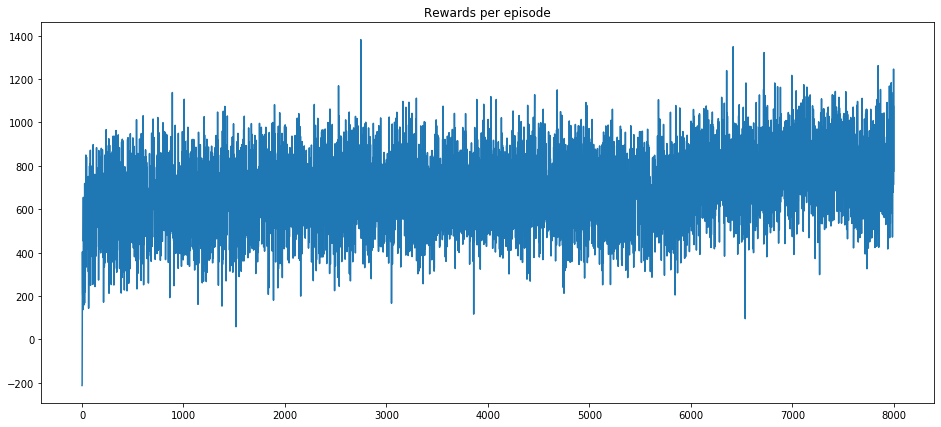

In [105]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)


In [106]:
### DQN for episodes 5000
Episodes = 5000

In [107]:
learning_rate = 0.01
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [2, 1, 3]
episode 0, reward -39.0, memory_length 139, epsilon 0.0005, time 747.0, rides 138
Initial State is  [2, 1, 3]
episode 1, reward 8.0, memory_length 251, epsilon 0.0005, time 728.0, rides 111
Initial State is  [2, 1, 3]
episode 2, reward 69.0, memory_length 354, epsilon 0.0005, time 731.0, rides 102
Initial State is  [2, 1, 3]
episode 3, reward 588.0, memory_length 458, epsilon 0.0005, time 724.0, rides 103
Initial State is  [2, 1, 3]
episode 4, reward 143.0, memory_length 563, epsilon 0.0005, time 732.0, rides 104
Initial State is  [2, 1, 3]
episode 5, reward 684.0, memory_length 687, epsilon 0.0005, time 727.0, rides 123
Initial State is  [2, 1, 3]
episode 6, reward 410.0, memory_length 806, epsilon 0.0005, time 736.0, rides 118
Initial State is  [2, 1, 3]
episode 7, reward 419.0, memory_length 930, epsilon 0.0005, time 727.0, rides 123
Initial State is  [2, 1, 3]
episode 8, reward 372.0, memory_length 1051, epsilon 0.0005, time 722.0, rides 120
Initial Stat

episode 73, reward 869.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 129
Initial State is  [2, 1, 3]
episode 74, reward 1327.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137
Initial State is  [2, 1, 3]
episode 75, reward 854.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 126
Initial State is  [2, 1, 3]
episode 76, reward 863.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [2, 1, 3]
episode 77, reward 524.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 114
Initial State is  [2, 1, 3]
episode 78, reward 630.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 114
Initial State is  [2, 1, 3]
episode 79, reward 849.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 80, reward 765.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 115
Initial State is  [2, 1, 3]
episode 81, reward 1119.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 123
Initial State is  

episode 146, reward 697.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 115
Initial State is  [2, 1, 3]
episode 147, reward 930.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [2, 1, 3]
episode 148, reward 1147.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [2, 1, 3]
episode 149, reward 797.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [2, 1, 3]
episode 150, reward 1157.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [2, 1, 3]
episode 151, reward 1134.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 120
Initial State is  [2, 1, 3]
episode 152, reward 1197.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 126
Initial State is  [2, 1, 3]
episode 153, reward 951.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 115
Initial State is  [2, 1, 3]
episode 154, reward 878.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 121
Initial

episode 219, reward 936.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 117
Initial State is  [2, 1, 3]
episode 220, reward 869.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 115
Initial State is  [2, 1, 3]
episode 221, reward 782.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 113
Initial State is  [2, 1, 3]
episode 222, reward 833.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 114
Initial State is  [2, 1, 3]
episode 223, reward 932.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 121
Initial State is  [2, 1, 3]
episode 224, reward 782.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 116
Initial State is  [2, 1, 3]
episode 225, reward 1188.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [2, 1, 3]
episode 226, reward 1167.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [2, 1, 3]
episode 227, reward 901.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial S

episode 292, reward 1052.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 117
Initial State is  [2, 1, 3]
episode 293, reward 1339.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 118
Initial State is  [2, 1, 3]
episode 294, reward 1320.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 113
Initial State is  [2, 1, 3]
episode 295, reward 741.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 121
Initial State is  [2, 1, 3]
episode 296, reward 754.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 118
Initial State is  [2, 1, 3]
episode 297, reward 866.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 111
Initial State is  [2, 1, 3]
episode 298, reward 1314.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 120
Initial State is  [2, 1, 3]
episode 299, reward 919.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 114
Initial State is  [2, 1, 3]
episode 300, reward 1060.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initia

episode 365, reward 1074.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 119
Initial State is  [2, 1, 3]
episode 366, reward 695.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 367, reward 1066.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 123
Initial State is  [2, 1, 3]
episode 368, reward 1054.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 116
Initial State is  [2, 1, 3]
episode 369, reward 971.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 117
Initial State is  [2, 1, 3]
episode 370, reward 1117.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 123
Initial State is  [2, 1, 3]
episode 371, reward 1068.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 114
Initial State is  [2, 1, 3]
episode 372, reward 1104.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 111
Initial State is  [2, 1, 3]
episode 373, reward 1043.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 115
Init

episode 438, reward 1200.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [2, 1, 3]
episode 439, reward 656.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 112
Initial State is  [2, 1, 3]
episode 440, reward 1080.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 133
Initial State is  [2, 1, 3]
episode 441, reward 999.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [2, 1, 3]
episode 442, reward 833.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 117
Initial State is  [2, 1, 3]
episode 443, reward 1282.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 129
Initial State is  [2, 1, 3]
episode 444, reward 975.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 128
Initial State is  [2, 1, 3]
episode 445, reward 1162.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 123
Initial State is  [2, 1, 3]
episode 446, reward 875.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial

episode 511, reward 605.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 115
Initial State is  [2, 1, 3]
episode 512, reward 1143.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [2, 1, 3]
episode 513, reward 1045.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 120
Initial State is  [2, 1, 3]
episode 514, reward 1038.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 125
Initial State is  [2, 1, 3]
episode 515, reward 881.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 113
Initial State is  [2, 1, 3]
episode 516, reward 1210.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 121
Initial State is  [2, 1, 3]
episode 517, reward 1016.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 114
Initial State is  [2, 1, 3]
episode 518, reward 1084.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 124
Initial State is  [2, 1, 3]
episode 519, reward 854.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 115
Initi

episode 584, reward 1003.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 119
Initial State is  [2, 1, 3]
episode 585, reward 1073.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [2, 1, 3]
episode 586, reward 1199.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [2, 1, 3]
episode 587, reward 1193.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 132
Initial State is  [2, 1, 3]
episode 588, reward 1159.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [2, 1, 3]
episode 589, reward 1162.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 110
Initial State is  [2, 1, 3]
episode 590, reward 848.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 118
Initial State is  [2, 1, 3]
episode 591, reward 872.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 118
Initial State is  [2, 1, 3]
episode 592, reward 708.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 109
Initi

episode 657, reward 1519.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 122
Initial State is  [2, 1, 3]
episode 658, reward 1173.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 120
Initial State is  [2, 1, 3]
episode 659, reward 1435.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [2, 1, 3]
episode 660, reward 1254.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 114
Initial State is  [2, 1, 3]
episode 661, reward 919.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 118
Initial State is  [2, 1, 3]
episode 662, reward 1144.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [2, 1, 3]
episode 663, reward 1100.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 120
Initial State is  [2, 1, 3]
episode 664, reward 1349.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 123
Initial State is  [2, 1, 3]
episode 665, reward 1321.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 129
Ini

episode 730, reward 1204.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 130
Initial State is  [2, 1, 3]
episode 731, reward 1047.0, memory_length 2000, epsilon 0.0005, time 743.0, rides 112
Initial State is  [2, 1, 3]
episode 732, reward 1022.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 733, reward 915.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 734, reward 1058.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 120
Initial State is  [2, 1, 3]
episode 735, reward 987.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 112
Initial State is  [2, 1, 3]
episode 736, reward 1143.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [2, 1, 3]
episode 737, reward 1065.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [2, 1, 3]
episode 738, reward 998.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initi

episode 803, reward 754.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [2, 1, 3]
episode 804, reward 1090.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [2, 1, 3]
episode 805, reward 1012.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 124
Initial State is  [2, 1, 3]
episode 806, reward 820.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 109
Initial State is  [2, 1, 3]
episode 807, reward 947.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 117
Initial State is  [2, 1, 3]
episode 808, reward 1306.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 115
Initial State is  [2, 1, 3]
episode 809, reward 1066.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 120
Initial State is  [2, 1, 3]
episode 810, reward 1106.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 124
Initial State is  [2, 1, 3]
episode 811, reward 888.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 118
Initia

episode 876, reward 916.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 119
Initial State is  [2, 1, 3]
episode 877, reward 1072.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 126
Initial State is  [2, 1, 3]
episode 878, reward 1057.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 119
Initial State is  [2, 1, 3]
episode 879, reward 1077.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 142
Initial State is  [2, 1, 3]
episode 880, reward 514.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 119
Initial State is  [2, 1, 3]
episode 881, reward 851.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 127
Initial State is  [2, 1, 3]
episode 882, reward 1006.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [2, 1, 3]
episode 883, reward 764.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 137
Initial State is  [2, 1, 3]
episode 884, reward 870.0, memory_length 2000, epsilon 0.0005, time 743.0, rides 129
Initial

episode 949, reward 725.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 114
Initial State is  [2, 1, 3]
episode 950, reward 814.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 120
Initial State is  [2, 1, 3]
episode 951, reward 809.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 124
Initial State is  [2, 1, 3]
episode 952, reward 998.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 123
Initial State is  [2, 1, 3]
episode 953, reward 837.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 954, reward 930.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [2, 1, 3]
episode 955, reward 1100.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 133
Initial State is  [2, 1, 3]
episode 956, reward 1056.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [2, 1, 3]
episode 957, reward 1016.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial 

episode 1022, reward 1003.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 134
Initial State is  [2, 1, 3]
episode 1023, reward 768.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [2, 1, 3]
episode 1024, reward 1043.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 117
Initial State is  [2, 1, 3]
episode 1025, reward 875.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 119
Initial State is  [2, 1, 3]
episode 1026, reward 727.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [2, 1, 3]
episode 1027, reward 882.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 116
Initial State is  [2, 1, 3]
episode 1028, reward 888.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [2, 1, 3]
episode 1029, reward 935.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [2, 1, 3]
episode 1030, reward 886.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130


episode 1094, reward 1064.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 113
Initial State is  [2, 1, 3]
episode 1095, reward 1054.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 137
Initial State is  [2, 1, 3]
episode 1096, reward 645.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 121
Initial State is  [2, 1, 3]
episode 1097, reward 726.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 116
Initial State is  [2, 1, 3]
episode 1098, reward 574.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [2, 1, 3]
episode 1099, reward 1048.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 140
Initial State is  [2, 1, 3]
episode 1100, reward 947.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [2, 1, 3]
episode 1101, reward 944.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 1102, reward 980.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 127

episode 1166, reward 837.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [2, 1, 3]
episode 1167, reward 1193.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 116
Initial State is  [2, 1, 3]
episode 1168, reward 686.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 139
Initial State is  [2, 1, 3]
episode 1169, reward 959.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [2, 1, 3]
episode 1170, reward 739.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [2, 1, 3]
episode 1171, reward 696.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 1172, reward 775.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 113
Initial State is  [2, 1, 3]
episode 1173, reward 949.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [2, 1, 3]
episode 1174, reward 1035.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130


episode 1238, reward 908.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 111
Initial State is  [2, 1, 3]
episode 1239, reward 983.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 139
Initial State is  [2, 1, 3]
episode 1240, reward 1019.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [2, 1, 3]
episode 1241, reward 1231.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [2, 1, 3]
episode 1242, reward 971.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 143
Initial State is  [2, 1, 3]
episode 1243, reward 752.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [2, 1, 3]
episode 1244, reward 845.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [2, 1, 3]
episode 1245, reward 989.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [2, 1, 3]
episode 1246, reward 1099.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 129

episode 1310, reward 1039.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 130
Initial State is  [2, 1, 3]
episode 1311, reward 1078.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 1312, reward 1056.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [2, 1, 3]
episode 1313, reward 702.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 122
Initial State is  [2, 1, 3]
episode 1314, reward 1163.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 138
Initial State is  [2, 1, 3]
episode 1315, reward 967.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 131
Initial State is  [2, 1, 3]
episode 1316, reward 907.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 113
Initial State is  [2, 1, 3]
episode 1317, reward 1094.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 1318, reward 697.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 1

episode 1382, reward 814.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [2, 1, 3]
episode 1383, reward 888.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 142
Initial State is  [2, 1, 3]
episode 1384, reward 845.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [2, 1, 3]
episode 1385, reward 1215.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 141
Initial State is  [2, 1, 3]
episode 1386, reward 886.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [2, 1, 3]
episode 1387, reward 1142.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 1388, reward 777.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [2, 1, 3]
episode 1389, reward 861.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 132
Initial State is  [2, 1, 3]
episode 1390, reward 895.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130


episode 1454, reward 961.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [2, 1, 3]
episode 1455, reward 732.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 145
Initial State is  [2, 1, 3]
episode 1456, reward 1280.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [2, 1, 3]
episode 1457, reward 784.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 143
Initial State is  [2, 1, 3]
episode 1458, reward 1000.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 131
Initial State is  [2, 1, 3]
episode 1459, reward 887.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [2, 1, 3]
episode 1460, reward 594.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [2, 1, 3]
episode 1461, reward 873.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 138
Initial State is  [2, 1, 3]
episode 1462, reward 847.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122


episode 1526, reward 439.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 132
Initial State is  [2, 1, 3]
episode 1527, reward 1040.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [2, 1, 3]
episode 1528, reward 1025.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 138
Initial State is  [2, 1, 3]
episode 1529, reward 1011.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 141
Initial State is  [2, 1, 3]
episode 1530, reward 1093.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
Initial State is  [2, 1, 3]
episode 1531, reward 982.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 140
Initial State is  [2, 1, 3]
episode 1532, reward 1038.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 127
Initial State is  [2, 1, 3]
episode 1533, reward 582.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 124
Initial State is  [2, 1, 3]
episode 1534, reward 1035.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 

episode 1598, reward 633.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 140
Initial State is  [2, 1, 3]
episode 1599, reward 1026.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
Initial State is  [2, 1, 3]
episode 1600, reward 1001.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 139
Initial State is  [2, 1, 3]
episode 1601, reward 985.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 133
Initial State is  [2, 1, 3]
episode 1602, reward 1152.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 148
Initial State is  [2, 1, 3]
episode 1603, reward 797.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [2, 1, 3]
episode 1604, reward 1075.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 119
Initial State is  [2, 1, 3]
episode 1605, reward 882.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [2, 1, 3]
episode 1606, reward 1024.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 1

episode 1670, reward 813.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 126
Initial State is  [2, 1, 3]
episode 1671, reward 766.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 131
Initial State is  [2, 1, 3]
episode 1672, reward 1170.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 130
Initial State is  [2, 1, 3]
episode 1673, reward 950.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 1674, reward 1001.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 120
Initial State is  [2, 1, 3]
episode 1675, reward 751.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [2, 1, 3]
episode 1676, reward 747.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 123
Initial State is  [2, 1, 3]
episode 1677, reward 798.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 116
Initial State is  [2, 1, 3]
episode 1678, reward 1331.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 145

episode 1742, reward 1133.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 125
Initial State is  [2, 1, 3]
episode 1743, reward 1066.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [2, 1, 3]
episode 1744, reward 871.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 123
Initial State is  [2, 1, 3]
episode 1745, reward 723.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 119
Initial State is  [2, 1, 3]
episode 1746, reward 660.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 119
Initial State is  [2, 1, 3]
episode 1747, reward 806.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 121
Initial State is  [2, 1, 3]
episode 1748, reward 795.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 112
Initial State is  [2, 1, 3]
episode 1749, reward 1013.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [2, 1, 3]
episode 1750, reward 901.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133

episode 1814, reward 1276.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 120
Initial State is  [2, 1, 3]
episode 1815, reward 1042.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [2, 1, 3]
episode 1816, reward 1140.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 114
Initial State is  [2, 1, 3]
episode 1817, reward 949.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 1818, reward 803.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 129
Initial State is  [2, 1, 3]
episode 1819, reward 689.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [2, 1, 3]
episode 1820, reward 590.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 112
Initial State is  [2, 1, 3]
episode 1821, reward 826.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [2, 1, 3]
episode 1822, reward 879.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126

episode 1886, reward 1036.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 129
Initial State is  [2, 1, 3]
episode 1887, reward 1019.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 129
Initial State is  [2, 1, 3]
episode 1888, reward 960.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [2, 1, 3]
episode 1889, reward 898.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 119
Initial State is  [2, 1, 3]
episode 1890, reward 1008.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [2, 1, 3]
episode 1891, reward 934.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [2, 1, 3]
episode 1892, reward 878.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 130
Initial State is  [2, 1, 3]
episode 1893, reward 1286.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 136
Initial State is  [2, 1, 3]
episode 1894, reward 821.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 13

episode 1958, reward 1023.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [2, 1, 3]
episode 1959, reward 1007.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 123
Initial State is  [2, 1, 3]
episode 1960, reward 928.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 131
Initial State is  [2, 1, 3]
episode 1961, reward 1052.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [2, 1, 3]
episode 1962, reward 787.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 129
Initial State is  [2, 1, 3]
episode 1963, reward 1010.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129
Initial State is  [2, 1, 3]
episode 1964, reward 1159.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 137
Initial State is  [2, 1, 3]
episode 1965, reward 1089.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [2, 1, 3]
episode 1966, reward 1213.0, memory_length 2000, epsilon 0.0005, time 733.0, rides

episode 2030, reward 893.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [2, 1, 3]
episode 2031, reward 964.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 117
Initial State is  [2, 1, 3]
episode 2032, reward 726.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 116
Initial State is  [2, 1, 3]
episode 2033, reward 937.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [2, 1, 3]
episode 2034, reward 980.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 128
Initial State is  [2, 1, 3]
episode 2035, reward 1002.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [2, 1, 3]
episode 2036, reward 864.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 2037, reward 1048.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 140
Initial State is  [2, 1, 3]
episode 2038, reward 882.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138


episode 2102, reward 801.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 136
Initial State is  [2, 1, 3]
episode 2103, reward 1056.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [2, 1, 3]
episode 2104, reward 629.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 132
Initial State is  [2, 1, 3]
episode 2105, reward 944.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 134
Initial State is  [2, 1, 3]
episode 2106, reward 912.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [2, 1, 3]
episode 2107, reward 1269.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 2108, reward 764.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [2, 1, 3]
episode 2109, reward 1180.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 138
Initial State is  [2, 1, 3]
episode 2110, reward 1321.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 12

episode 2174, reward 839.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 2175, reward 1105.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 138
Initial State is  [2, 1, 3]
episode 2176, reward 672.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 139
Initial State is  [2, 1, 3]
episode 2177, reward 649.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 125
Initial State is  [2, 1, 3]
episode 2178, reward 1223.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 134
Initial State is  [2, 1, 3]
episode 2179, reward 901.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 2180, reward 1011.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 123
Initial State is  [2, 1, 3]
episode 2181, reward 1040.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [2, 1, 3]
episode 2182, reward 992.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 13

episode 2246, reward 1000.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [2, 1, 3]
episode 2247, reward 797.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [2, 1, 3]
episode 2248, reward 1144.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 130
Initial State is  [2, 1, 3]
episode 2249, reward 966.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 2250, reward 992.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 117
Initial State is  [2, 1, 3]
episode 2251, reward 896.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 121
Initial State is  [2, 1, 3]
episode 2252, reward 1152.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 2253, reward 863.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [2, 1, 3]
episode 2254, reward 928.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125

episode 2318, reward 997.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 2319, reward 803.0, memory_length 2000, epsilon 0.0005, time 743.0, rides 135
Initial State is  [2, 1, 3]
episode 2320, reward 627.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 146
Initial State is  [2, 1, 3]
episode 2321, reward 800.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [2, 1, 3]
episode 2322, reward 931.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [2, 1, 3]
episode 2323, reward 646.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 119
Initial State is  [2, 1, 3]
episode 2324, reward 744.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 144
Initial State is  [2, 1, 3]
episode 2325, reward 1003.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 127
Initial State is  [2, 1, 3]
episode 2326, reward 966.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 120
I

episode 2390, reward 741.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 128
Initial State is  [2, 1, 3]
episode 2391, reward 843.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [2, 1, 3]
episode 2392, reward 1135.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 132
Initial State is  [2, 1, 3]
episode 2393, reward 1039.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 123
Initial State is  [2, 1, 3]
episode 2394, reward 997.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 2395, reward 1069.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [2, 1, 3]
episode 2396, reward 992.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 117
Initial State is  [2, 1, 3]
episode 2397, reward 1175.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [2, 1, 3]
episode 2398, reward 749.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 11

episode 2462, reward 876.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 120
Initial State is  [2, 1, 3]
episode 2463, reward 1126.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 123
Initial State is  [2, 1, 3]
episode 2464, reward 988.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 124
Initial State is  [2, 1, 3]
episode 2465, reward 720.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 124
Initial State is  [2, 1, 3]
episode 2466, reward 1134.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 124
Initial State is  [2, 1, 3]
episode 2467, reward 1009.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 119
Initial State is  [2, 1, 3]
episode 2468, reward 1149.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 121
Initial State is  [2, 1, 3]
episode 2469, reward 1095.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [2, 1, 3]
episode 2470, reward 893.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 1

episode 2534, reward 715.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [2, 1, 3]
episode 2535, reward 1178.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [2, 1, 3]
episode 2536, reward 1032.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 139
Initial State is  [2, 1, 3]
episode 2537, reward 713.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [2, 1, 3]
episode 2538, reward 962.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
Initial State is  [2, 1, 3]
episode 2539, reward 759.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [2, 1, 3]
episode 2540, reward 1064.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 120
Initial State is  [2, 1, 3]
episode 2541, reward 985.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 128
Initial State is  [2, 1, 3]
episode 2542, reward 1233.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 13

episode 2606, reward 912.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 136
Initial State is  [2, 1, 3]
episode 2607, reward 1103.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 133
Initial State is  [2, 1, 3]
episode 2608, reward 1036.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 141
Initial State is  [2, 1, 3]
episode 2609, reward 1041.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 112
Initial State is  [2, 1, 3]
episode 2610, reward 980.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 125
Initial State is  [2, 1, 3]
episode 2611, reward 902.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 123
Initial State is  [2, 1, 3]
episode 2612, reward 1271.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 2613, reward 921.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [2, 1, 3]
episode 2614, reward 951.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 12

episode 2678, reward 864.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 2679, reward 792.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 133
Initial State is  [2, 1, 3]
episode 2680, reward 857.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 121
Initial State is  [2, 1, 3]
episode 2681, reward 916.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 124
Initial State is  [2, 1, 3]
episode 2682, reward 1052.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 133
Initial State is  [2, 1, 3]
episode 2683, reward 776.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 116
Initial State is  [2, 1, 3]
episode 2684, reward 695.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 2685, reward 1002.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 132
Initial State is  [2, 1, 3]
episode 2686, reward 892.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122


episode 2750, reward 747.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 126
Initial State is  [2, 1, 3]
episode 2751, reward 1033.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [2, 1, 3]
episode 2752, reward 1129.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [2, 1, 3]
episode 2753, reward 921.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 137
Initial State is  [2, 1, 3]
episode 2754, reward 905.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [2, 1, 3]
episode 2755, reward 730.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 148
Initial State is  [2, 1, 3]
episode 2756, reward 925.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 139
Initial State is  [2, 1, 3]
episode 2757, reward 946.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [2, 1, 3]
episode 2758, reward 753.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132


episode 2822, reward 627.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 2823, reward 1208.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 2824, reward 736.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [2, 1, 3]
episode 2825, reward 764.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 133
Initial State is  [2, 1, 3]
episode 2826, reward 1016.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 2827, reward 1103.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 119
Initial State is  [2, 1, 3]
episode 2828, reward 840.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 141
Initial State is  [2, 1, 3]
episode 2829, reward 690.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 2830, reward 1064.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 12

episode 2894, reward 961.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 135
Initial State is  [2, 1, 3]
episode 2895, reward 917.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 113
Initial State is  [2, 1, 3]
episode 2896, reward 847.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 114
Initial State is  [2, 1, 3]
episode 2897, reward 635.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 118
Initial State is  [2, 1, 3]
episode 2898, reward 660.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [2, 1, 3]
episode 2899, reward 1187.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 2900, reward 847.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [2, 1, 3]
episode 2901, reward 1007.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [2, 1, 3]
episode 2902, reward 1159.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 118

episode 2966, reward 837.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [2, 1, 3]
episode 2967, reward 971.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [2, 1, 3]
episode 2968, reward 1086.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 134
Initial State is  [2, 1, 3]
episode 2969, reward 1023.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 133
Initial State is  [2, 1, 3]
episode 2970, reward 1080.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [2, 1, 3]
episode 2971, reward 954.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 2972, reward 889.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 130
Initial State is  [2, 1, 3]
episode 2973, reward 1016.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [2, 1, 3]
episode 2974, reward 1027.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 1

episode 3038, reward 918.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 112
Initial State is  [2, 1, 3]
episode 3039, reward 1108.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [2, 1, 3]
episode 3040, reward 616.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 123
Initial State is  [2, 1, 3]
episode 3041, reward 770.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [2, 1, 3]
episode 3042, reward 605.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 132
Initial State is  [2, 1, 3]
episode 3043, reward 808.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [2, 1, 3]
episode 3044, reward 868.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [2, 1, 3]
episode 3045, reward 838.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 3046, reward 876.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 118
I

episode 3110, reward 978.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 122
Initial State is  [2, 1, 3]
episode 3111, reward 948.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 117
Initial State is  [2, 1, 3]
episode 3112, reward 839.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [2, 1, 3]
episode 3113, reward 873.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 128
Initial State is  [2, 1, 3]
episode 3114, reward 1014.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 135
Initial State is  [2, 1, 3]
episode 3115, reward 712.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 114
Initial State is  [2, 1, 3]
episode 3116, reward 704.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 117
Initial State is  [2, 1, 3]
episode 3117, reward 967.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 131
Initial State is  [2, 1, 3]
episode 3118, reward 1033.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 123


episode 3182, reward 997.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 123
Initial State is  [2, 1, 3]
episode 3183, reward 1103.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 3184, reward 900.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 123
Initial State is  [2, 1, 3]
episode 3185, reward 819.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 125
Initial State is  [2, 1, 3]
episode 3186, reward 850.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 121
Initial State is  [2, 1, 3]
episode 3187, reward 1121.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 127
Initial State is  [2, 1, 3]
episode 3188, reward 970.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 131
Initial State is  [2, 1, 3]
episode 3189, reward 767.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 126
Initial State is  [2, 1, 3]
episode 3190, reward 1089.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137

episode 3254, reward 922.0, memory_length 2000, epsilon 0.0005, time 744.0, rides 130
Initial State is  [2, 1, 3]
episode 3255, reward 1132.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 142
Initial State is  [2, 1, 3]
episode 3256, reward 1119.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120
Initial State is  [2, 1, 3]
episode 3257, reward 933.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 140
Initial State is  [2, 1, 3]
episode 3258, reward 1302.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [2, 1, 3]
episode 3259, reward 750.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 129
Initial State is  [2, 1, 3]
episode 3260, reward 749.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [2, 1, 3]
episode 3261, reward 1305.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 140
Initial State is  [2, 1, 3]
episode 3262, reward 1022.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 1

episode 3326, reward 1232.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [2, 1, 3]
episode 3327, reward 1037.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 123
Initial State is  [2, 1, 3]
episode 3328, reward 531.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 120
Initial State is  [2, 1, 3]
episode 3329, reward 757.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [2, 1, 3]
episode 3330, reward 903.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 118
Initial State is  [2, 1, 3]
episode 3331, reward 981.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [2, 1, 3]
episode 3332, reward 1189.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 123
Initial State is  [2, 1, 3]
episode 3333, reward 770.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 3334, reward 915.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120

episode 3398, reward 952.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 117
Initial State is  [2, 1, 3]
episode 3399, reward 981.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 137
Initial State is  [2, 1, 3]
episode 3400, reward 626.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 125
Initial State is  [2, 1, 3]
episode 3401, reward 1150.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [2, 1, 3]
episode 3402, reward 571.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 131
Initial State is  [2, 1, 3]
episode 3403, reward 718.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 132
Initial State is  [2, 1, 3]
episode 3404, reward 1124.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [2, 1, 3]
episode 3405, reward 938.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [2, 1, 3]
episode 3406, reward 909.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129


episode 3470, reward 418.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 131
Initial State is  [2, 1, 3]
episode 3471, reward 904.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 136
Initial State is  [2, 1, 3]
episode 3472, reward 705.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 117
Initial State is  [2, 1, 3]
episode 3473, reward 895.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 120
Initial State is  [2, 1, 3]
episode 3474, reward 923.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 124
Initial State is  [2, 1, 3]
episode 3475, reward 835.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 3476, reward 725.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [2, 1, 3]
episode 3477, reward 909.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [2, 1, 3]
episode 3478, reward 874.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 132
In

episode 3542, reward 1114.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 113
Initial State is  [2, 1, 3]
episode 3543, reward 1207.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 124
Initial State is  [2, 1, 3]
episode 3544, reward 884.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [2, 1, 3]
episode 3545, reward 1253.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [2, 1, 3]
episode 3546, reward 951.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 118
Initial State is  [2, 1, 3]
episode 3547, reward 820.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 133
Initial State is  [2, 1, 3]
episode 3548, reward 1100.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [2, 1, 3]
episode 3549, reward 902.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 125
Initial State is  [2, 1, 3]
episode 3550, reward 1027.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 1

episode 3614, reward 1084.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [2, 1, 3]
episode 3615, reward 874.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 121
Initial State is  [2, 1, 3]
episode 3616, reward 887.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 120
Initial State is  [2, 1, 3]
episode 3617, reward 1078.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [2, 1, 3]
episode 3618, reward 1010.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 3619, reward 1269.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 126
Initial State is  [2, 1, 3]
episode 3620, reward 1079.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [2, 1, 3]
episode 3621, reward 611.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [2, 1, 3]
episode 3622, reward 1071.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 

episode 3686, reward 986.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 133
Initial State is  [2, 1, 3]
episode 3687, reward 614.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [2, 1, 3]
episode 3688, reward 1061.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [2, 1, 3]
episode 3689, reward 869.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [2, 1, 3]
episode 3690, reward 907.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 131
Initial State is  [2, 1, 3]
episode 3691, reward 1200.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 125
Initial State is  [2, 1, 3]
episode 3692, reward 851.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [2, 1, 3]
episode 3693, reward 678.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 113
Initial State is  [2, 1, 3]
episode 3694, reward 980.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136


episode 3758, reward 1176.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [2, 1, 3]
episode 3759, reward 744.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 128
Initial State is  [2, 1, 3]
episode 3760, reward 803.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 130
Initial State is  [2, 1, 3]
episode 3761, reward 953.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 138
Initial State is  [2, 1, 3]
episode 3762, reward 1036.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 133
Initial State is  [2, 1, 3]
episode 3763, reward 849.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [2, 1, 3]
episode 3764, reward 1126.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 3765, reward 998.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 3766, reward 887.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 119

episode 3830, reward 1038.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131
Initial State is  [2, 1, 3]
episode 3831, reward 867.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 132
Initial State is  [2, 1, 3]
episode 3832, reward 937.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [2, 1, 3]
episode 3833, reward 939.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [2, 1, 3]
episode 3834, reward 853.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 125
Initial State is  [2, 1, 3]
episode 3835, reward 869.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [2, 1, 3]
episode 3836, reward 1089.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [2, 1, 3]
episode 3837, reward 1031.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [2, 1, 3]
episode 3838, reward 790.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124

episode 3902, reward 837.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 127
Initial State is  [2, 1, 3]
episode 3903, reward 934.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [2, 1, 3]
episode 3904, reward 1187.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 130
Initial State is  [2, 1, 3]
episode 3905, reward 1080.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 120
Initial State is  [2, 1, 3]
episode 3906, reward 1214.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [2, 1, 3]
episode 3907, reward 895.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 125
Initial State is  [2, 1, 3]
episode 3908, reward 847.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 117
Initial State is  [2, 1, 3]
episode 3909, reward 946.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 129
Initial State is  [2, 1, 3]
episode 3910, reward 603.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 125

episode 3974, reward 1116.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 3975, reward 824.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 127
Initial State is  [2, 1, 3]
episode 3976, reward 1004.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 3977, reward 930.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129
Initial State is  [2, 1, 3]
episode 3978, reward 829.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [2, 1, 3]
episode 3979, reward 1031.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 132
Initial State is  [2, 1, 3]
episode 3980, reward 1159.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [2, 1, 3]
episode 3981, reward 1129.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [2, 1, 3]
episode 3982, reward 696.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 1

episode 4046, reward 893.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 137
Initial State is  [2, 1, 3]
episode 4047, reward 1140.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [2, 1, 3]
episode 4048, reward 813.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [2, 1, 3]
episode 4049, reward 1129.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [2, 1, 3]
episode 4050, reward 1176.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [2, 1, 3]
episode 4051, reward 840.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [2, 1, 3]
episode 4052, reward 842.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 131
Initial State is  [2, 1, 3]
episode 4053, reward 841.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 135
Initial State is  [2, 1, 3]
episode 4054, reward 802.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128

episode 4118, reward 845.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 126
Initial State is  [2, 1, 3]
episode 4119, reward 1050.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [2, 1, 3]
episode 4120, reward 863.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [2, 1, 3]
episode 4121, reward 1023.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [2, 1, 3]
episode 4122, reward 1022.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [2, 1, 3]
episode 4123, reward 859.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [2, 1, 3]
episode 4124, reward 794.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 4125, reward 824.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 125
Initial State is  [2, 1, 3]
episode 4126, reward 1185.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 10

episode 4190, reward 924.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 133
Initial State is  [2, 1, 3]
episode 4191, reward 1123.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 132
Initial State is  [2, 1, 3]
episode 4192, reward 797.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [2, 1, 3]
episode 4193, reward 781.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [2, 1, 3]
episode 4194, reward 887.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 123
Initial State is  [2, 1, 3]
episode 4195, reward 843.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 134
Initial State is  [2, 1, 3]
episode 4196, reward 997.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [2, 1, 3]
episode 4197, reward 863.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [2, 1, 3]
episode 4198, reward 825.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 121
I

episode 4262, reward 770.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 121
Initial State is  [2, 1, 3]
episode 4263, reward 993.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 140
Initial State is  [2, 1, 3]
episode 4264, reward 1068.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [2, 1, 3]
episode 4265, reward 962.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 140
Initial State is  [2, 1, 3]
episode 4266, reward 1217.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 132
Initial State is  [2, 1, 3]
episode 4267, reward 1000.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [2, 1, 3]
episode 4268, reward 803.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 137
Initial State is  [2, 1, 3]
episode 4269, reward 751.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 123
Initial State is  [2, 1, 3]
episode 4270, reward 990.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123

episode 4334, reward 871.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [2, 1, 3]
episode 4335, reward 1131.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [2, 1, 3]
episode 4336, reward 890.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 127
Initial State is  [2, 1, 3]
episode 4337, reward 885.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 127
Initial State is  [2, 1, 3]
episode 4338, reward 983.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 4339, reward 1017.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [2, 1, 3]
episode 4340, reward 593.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [2, 1, 3]
episode 4341, reward 854.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 130
Initial State is  [2, 1, 3]
episode 4342, reward 1118.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137

episode 4406, reward 812.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 146
Initial State is  [2, 1, 3]
episode 4407, reward 801.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 135
Initial State is  [2, 1, 3]
episode 4408, reward 705.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 124
Initial State is  [2, 1, 3]
episode 4409, reward 822.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 130
Initial State is  [2, 1, 3]
episode 4410, reward 1033.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 117
Initial State is  [2, 1, 3]
episode 4411, reward 781.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 142
Initial State is  [2, 1, 3]
episode 4412, reward 1036.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 132
Initial State is  [2, 1, 3]
episode 4413, reward 986.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 116
Initial State is  [2, 1, 3]
episode 4414, reward 1317.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133

episode 4478, reward 805.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
Initial State is  [2, 1, 3]
episode 4479, reward 1128.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 130
Initial State is  [2, 1, 3]
episode 4480, reward 1228.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 146
Initial State is  [2, 1, 3]
episode 4481, reward 1019.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [2, 1, 3]
episode 4482, reward 848.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 147
Initial State is  [2, 1, 3]
episode 4483, reward 840.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [2, 1, 3]
episode 4484, reward 1201.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [2, 1, 3]
episode 4485, reward 742.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 125
Initial State is  [2, 1, 3]
episode 4486, reward 1278.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 1

episode 4550, reward 841.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 142
Initial State is  [2, 1, 3]
episode 4551, reward 878.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 136
Initial State is  [2, 1, 3]
episode 4552, reward 848.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 121
Initial State is  [2, 1, 3]
episode 4553, reward 719.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 119
Initial State is  [2, 1, 3]
episode 4554, reward 973.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 115
Initial State is  [2, 1, 3]
episode 4555, reward 678.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 114
Initial State is  [2, 1, 3]
episode 4556, reward 839.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 124
Initial State is  [2, 1, 3]
episode 4557, reward 1052.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120
Initial State is  [2, 1, 3]
episode 4558, reward 882.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
I

episode 4622, reward 968.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 146
Initial State is  [2, 1, 3]
episode 4623, reward 804.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 128
Initial State is  [2, 1, 3]
episode 4624, reward 752.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 111
Initial State is  [2, 1, 3]
episode 4625, reward 842.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 118
Initial State is  [2, 1, 3]
episode 4626, reward 1162.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [2, 1, 3]
episode 4627, reward 1108.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 127
Initial State is  [2, 1, 3]
episode 4628, reward 510.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 144
Initial State is  [2, 1, 3]
episode 4629, reward 955.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [2, 1, 3]
episode 4630, reward 949.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 140


episode 4694, reward 1274.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 136
Initial State is  [2, 1, 3]
episode 4695, reward 825.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 139
Initial State is  [2, 1, 3]
episode 4696, reward 1181.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 140
Initial State is  [2, 1, 3]
episode 4697, reward 1013.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 4698, reward 1002.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [2, 1, 3]
episode 4699, reward 933.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 118
Initial State is  [2, 1, 3]
episode 4700, reward 1040.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 4701, reward 808.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 117
Initial State is  [2, 1, 3]
episode 4702, reward 898.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 1

episode 4766, reward 831.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 143
Initial State is  [2, 1, 3]
episode 4767, reward 742.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 122
Initial State is  [2, 1, 3]
episode 4768, reward 967.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [2, 1, 3]
episode 4769, reward 736.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 113
Initial State is  [2, 1, 3]
episode 4770, reward 946.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [2, 1, 3]
episode 4771, reward 1135.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 139
Initial State is  [2, 1, 3]
episode 4772, reward 916.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 138
Initial State is  [2, 1, 3]
episode 4773, reward 744.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [2, 1, 3]
episode 4774, reward 656.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 117
I

episode 4838, reward 1122.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [2, 1, 3]
episode 4839, reward 651.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 134
Initial State is  [2, 1, 3]
episode 4840, reward 1239.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 123
Initial State is  [2, 1, 3]
episode 4841, reward 1052.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [2, 1, 3]
episode 4842, reward 1189.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [2, 1, 3]
episode 4843, reward 1330.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 128
Initial State is  [2, 1, 3]
episode 4844, reward 804.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 4845, reward 743.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 140
Initial State is  [2, 1, 3]
episode 4846, reward 752.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 1

episode 4910, reward 793.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [2, 1, 3]
episode 4911, reward 1003.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 136
Initial State is  [2, 1, 3]
episode 4912, reward 1072.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137
Initial State is  [2, 1, 3]
episode 4913, reward 1097.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 125
Initial State is  [2, 1, 3]
episode 4914, reward 1206.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 141
Initial State is  [2, 1, 3]
episode 4915, reward 1052.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [2, 1, 3]
episode 4916, reward 903.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [2, 1, 3]
episode 4917, reward 917.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 135
Initial State is  [2, 1, 3]
episode 4918, reward 727.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 1

episode 4982, reward 900.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 133
Initial State is  [2, 1, 3]
episode 4983, reward 933.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [2, 1, 3]
episode 4984, reward 973.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 141
Initial State is  [2, 1, 3]
episode 4985, reward 1013.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 134
Initial State is  [2, 1, 3]
episode 4986, reward 966.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 130
Initial State is  [2, 1, 3]
episode 4987, reward 783.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [2, 1, 3]
episode 4988, reward 865.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [2, 1, 3]
episode 4989, reward 796.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 4990, reward 855.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
I

In [108]:
agent.memory

deque([(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        20,
        3.0,
        array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        False),
       (array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        0,
        -5,
        array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        False),
       (array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

### Tracking Convergence

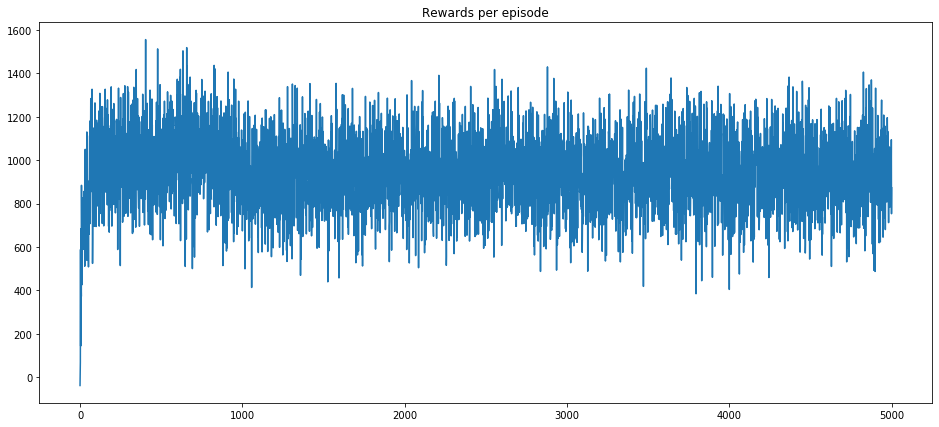

In [109]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)

In [110]:
### Reducing Learning rate Further

In [111]:
#### Final DQN block LR 0.001 and Episodes 5000

In [112]:
#Finalised DQN block
learning_rate = 0.001
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [2, 1, 3]
episode 0, reward -239.0, memory_length 142, epsilon 0.0005, time 733.0, rides 141
Initial State is  [2, 1, 3]
episode 1, reward 167.0, memory_length 252, epsilon 0.0005, time 737.0, rides 109
Initial State is  [2, 1, 3]
episode 2, reward -24.0, memory_length 348, epsilon 0.0005, time 739.0, rides 95
Initial State is  [2, 1, 3]
episode 3, reward -42.0, memory_length 449, epsilon 0.0005, time 734.0, rides 100
Initial State is  [2, 1, 3]
episode 4, reward 125.0, memory_length 556, epsilon 0.0005, time 726.0, rides 106
Initial State is  [2, 1, 3]
episode 5, reward 133.0, memory_length 664, epsilon 0.0005, time 724.0, rides 107
Initial State is  [2, 1, 3]
episode 6, reward 286.0, memory_length 767, epsilon 0.0005, time 732.0, rides 102
Initial State is  [2, 1, 3]
episode 7, reward 237.0, memory_length 874, epsilon 0.0005, time 738.0, rides 106
Initial State is  [2, 1, 3]
episode 8, reward 314.0, memory_length 983, epsilon 0.0005, time 732.0, rides 108
Initial St

episode 74, reward 747.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120
Initial State is  [2, 1, 3]
episode 75, reward 905.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136
Initial State is  [2, 1, 3]
episode 76, reward 460.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [2, 1, 3]
episode 77, reward 607.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 121
Initial State is  [2, 1, 3]
episode 78, reward 807.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 120
Initial State is  [2, 1, 3]
episode 79, reward 896.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 80, reward 357.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 81, reward 791.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 123
Initial State is  [2, 1, 3]
episode 82, reward 869.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [2

episode 147, reward 893.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 125
Initial State is  [2, 1, 3]
episode 148, reward 879.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [2, 1, 3]
episode 149, reward 527.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 131
Initial State is  [2, 1, 3]
episode 150, reward 704.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 127
Initial State is  [2, 1, 3]
episode 151, reward 737.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 119
Initial State is  [2, 1, 3]
episode 152, reward 636.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 139
Initial State is  [2, 1, 3]
episode 153, reward 696.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 114
Initial State is  [2, 1, 3]
episode 154, reward 718.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 125
Initial State is  [2, 1, 3]
episode 155, reward 559.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 127
Initial Sta

episode 220, reward 591.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 117
Initial State is  [2, 1, 3]
episode 221, reward 976.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [2, 1, 3]
episode 222, reward 738.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 118
Initial State is  [2, 1, 3]
episode 223, reward 786.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 114
Initial State is  [2, 1, 3]
episode 224, reward 787.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 225, reward 764.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [2, 1, 3]
episode 226, reward 808.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [2, 1, 3]
episode 227, reward 584.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 128
Initial State is  [2, 1, 3]
episode 228, reward 566.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial Sta

episode 293, reward 888.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [2, 1, 3]
episode 294, reward 959.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 117
Initial State is  [2, 1, 3]
episode 295, reward 852.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 125
Initial State is  [2, 1, 3]
episode 296, reward 695.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [2, 1, 3]
episode 297, reward 1027.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 141
Initial State is  [2, 1, 3]
episode 298, reward 1005.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 137
Initial State is  [2, 1, 3]
episode 299, reward 659.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 130
Initial State is  [2, 1, 3]
episode 300, reward 1213.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 124
Initial State is  [2, 1, 3]
episode 301, reward 814.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial 

episode 366, reward 705.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 367, reward 943.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 141
Initial State is  [2, 1, 3]
episode 368, reward 971.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 369, reward 1137.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 127
Initial State is  [2, 1, 3]
episode 370, reward 800.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 122
Initial State is  [2, 1, 3]
episode 371, reward 765.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [2, 1, 3]
episode 372, reward 908.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 118
Initial State is  [2, 1, 3]
episode 373, reward 820.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [2, 1, 3]
episode 374, reward 991.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial St

episode 439, reward 988.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [2, 1, 3]
episode 440, reward 907.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 114
Initial State is  [2, 1, 3]
episode 441, reward 849.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 122
Initial State is  [2, 1, 3]
episode 442, reward 888.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 123
Initial State is  [2, 1, 3]
episode 443, reward 795.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 126
Initial State is  [2, 1, 3]
episode 444, reward 871.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [2, 1, 3]
episode 445, reward 869.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [2, 1, 3]
episode 446, reward 808.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 116
Initial State is  [2, 1, 3]
episode 447, reward 574.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 118
Initial Sta

episode 512, reward 661.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 121
Initial State is  [2, 1, 3]
episode 513, reward 664.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 120
Initial State is  [2, 1, 3]
episode 514, reward 1010.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [2, 1, 3]
episode 515, reward 1280.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [2, 1, 3]
episode 516, reward 928.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 129
Initial State is  [2, 1, 3]
episode 517, reward 643.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 123
Initial State is  [2, 1, 3]
episode 518, reward 873.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [2, 1, 3]
episode 519, reward 1047.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [2, 1, 3]
episode 520, reward 693.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial 

episode 585, reward 860.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 124
Initial State is  [2, 1, 3]
episode 586, reward 879.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 115
Initial State is  [2, 1, 3]
episode 587, reward 666.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 137
Initial State is  [2, 1, 3]
episode 588, reward 640.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [2, 1, 3]
episode 589, reward 974.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 121
Initial State is  [2, 1, 3]
episode 590, reward 585.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 132
Initial State is  [2, 1, 3]
episode 591, reward 804.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 135
Initial State is  [2, 1, 3]
episode 592, reward 838.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [2, 1, 3]
episode 593, reward 936.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 119
Initial Sta

episode 658, reward 970.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 127
Initial State is  [2, 1, 3]
episode 659, reward 1144.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 133
Initial State is  [2, 1, 3]
episode 660, reward 903.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [2, 1, 3]
episode 661, reward 753.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [2, 1, 3]
episode 662, reward 841.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [2, 1, 3]
episode 663, reward 636.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [2, 1, 3]
episode 664, reward 998.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [2, 1, 3]
episode 665, reward 827.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 129
Initial State is  [2, 1, 3]
episode 666, reward 691.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 124
Initial St

episode 731, reward 875.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 127
Initial State is  [2, 1, 3]
episode 732, reward 770.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 139
Initial State is  [2, 1, 3]
episode 733, reward 1267.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [2, 1, 3]
episode 734, reward 1155.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 132
Initial State is  [2, 1, 3]
episode 735, reward 808.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 128
Initial State is  [2, 1, 3]
episode 736, reward 1031.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 134
Initial State is  [2, 1, 3]
episode 737, reward 1003.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 113
Initial State is  [2, 1, 3]
episode 738, reward 1037.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 119
Initial State is  [2, 1, 3]
episode 739, reward 588.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 121
Initia

episode 804, reward 651.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [2, 1, 3]
episode 805, reward 885.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [2, 1, 3]
episode 806, reward 894.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 128
Initial State is  [2, 1, 3]
episode 807, reward 870.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [2, 1, 3]
episode 808, reward 638.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [2, 1, 3]
episode 809, reward 1023.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 810, reward 898.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [2, 1, 3]
episode 811, reward 1016.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [2, 1, 3]
episode 812, reward 1267.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 127
Initial 

episode 877, reward 984.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 147
Initial State is  [2, 1, 3]
episode 878, reward 1072.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 135
Initial State is  [2, 1, 3]
episode 879, reward 746.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 118
Initial State is  [2, 1, 3]
episode 880, reward 841.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [2, 1, 3]
episode 881, reward 811.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 125
Initial State is  [2, 1, 3]
episode 882, reward 819.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
Initial State is  [2, 1, 3]
episode 883, reward 878.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 133
Initial State is  [2, 1, 3]
episode 884, reward 963.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 127
Initial State is  [2, 1, 3]
episode 885, reward 772.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 139
Initial St

episode 950, reward 1025.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 141
Initial State is  [2, 1, 3]
episode 951, reward 1124.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 952, reward 758.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [2, 1, 3]
episode 953, reward 862.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 145
Initial State is  [2, 1, 3]
episode 954, reward 1088.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 143
Initial State is  [2, 1, 3]
episode 955, reward 947.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 115
Initial State is  [2, 1, 3]
episode 956, reward 1081.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [2, 1, 3]
episode 957, reward 742.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 137
Initial State is  [2, 1, 3]
episode 958, reward 1008.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initia

episode 1023, reward 1031.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 124
Initial State is  [2, 1, 3]
episode 1024, reward 623.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 120
Initial State is  [2, 1, 3]
episode 1025, reward 846.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 133
Initial State is  [2, 1, 3]
episode 1026, reward 866.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 139
Initial State is  [2, 1, 3]
episode 1027, reward 855.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 1028, reward 1055.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 123
Initial State is  [2, 1, 3]
episode 1029, reward 955.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [2, 1, 3]
episode 1030, reward 668.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 1031, reward 915.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 127


episode 1095, reward 953.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 123
Initial State is  [2, 1, 3]
episode 1096, reward 797.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [2, 1, 3]
episode 1097, reward 902.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [2, 1, 3]
episode 1098, reward 1029.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [2, 1, 3]
episode 1099, reward 888.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 146
Initial State is  [2, 1, 3]
episode 1100, reward 652.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 1101, reward 887.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [2, 1, 3]
episode 1102, reward 1028.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 121
Initial State is  [2, 1, 3]
episode 1103, reward 984.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133


episode 1167, reward 1257.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 129
Initial State is  [2, 1, 3]
episode 1168, reward 1048.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 124
Initial State is  [2, 1, 3]
episode 1169, reward 1017.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [2, 1, 3]
episode 1170, reward 898.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 113
Initial State is  [2, 1, 3]
episode 1171, reward 852.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 1172, reward 882.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 126
Initial State is  [2, 1, 3]
episode 1173, reward 900.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 137
Initial State is  [2, 1, 3]
episode 1174, reward 1028.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [2, 1, 3]
episode 1175, reward 1626.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 1

episode 1239, reward 1299.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 132
Initial State is  [2, 1, 3]
episode 1240, reward 845.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 132
Initial State is  [2, 1, 3]
episode 1241, reward 959.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [2, 1, 3]
episode 1242, reward 850.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 137
Initial State is  [2, 1, 3]
episode 1243, reward 1058.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137
Initial State is  [2, 1, 3]
episode 1244, reward 796.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 127
Initial State is  [2, 1, 3]
episode 1245, reward 755.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [2, 1, 3]
episode 1246, reward 967.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 124
Initial State is  [2, 1, 3]
episode 1247, reward 990.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 124


episode 1311, reward 738.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 117
Initial State is  [2, 1, 3]
episode 1312, reward 1325.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 129
Initial State is  [2, 1, 3]
episode 1313, reward 856.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [2, 1, 3]
episode 1314, reward 1141.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [2, 1, 3]
episode 1315, reward 700.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [2, 1, 3]
episode 1316, reward 803.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [2, 1, 3]
episode 1317, reward 1145.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [2, 1, 3]
episode 1318, reward 741.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 1319, reward 1191.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 13

episode 1383, reward 944.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [2, 1, 3]
episode 1384, reward 955.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 130
Initial State is  [2, 1, 3]
episode 1385, reward 1346.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 133
Initial State is  [2, 1, 3]
episode 1386, reward 961.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [2, 1, 3]
episode 1387, reward 849.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 135
Initial State is  [2, 1, 3]
episode 1388, reward 849.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [2, 1, 3]
episode 1389, reward 914.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [2, 1, 3]
episode 1390, reward 1025.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 133
Initial State is  [2, 1, 3]
episode 1391, reward 1009.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132

episode 1455, reward 1043.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [2, 1, 3]
episode 1456, reward 905.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [2, 1, 3]
episode 1457, reward 1074.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 117
Initial State is  [2, 1, 3]
episode 1458, reward 510.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [2, 1, 3]
episode 1459, reward 1183.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 114
Initial State is  [2, 1, 3]
episode 1460, reward 1125.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [2, 1, 3]
episode 1461, reward 940.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [2, 1, 3]
episode 1462, reward 940.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 1463, reward 1114.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 1

episode 1527, reward 1092.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [2, 1, 3]
episode 1528, reward 1139.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 132
Initial State is  [2, 1, 3]
episode 1529, reward 953.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [2, 1, 3]
episode 1530, reward 801.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 129
Initial State is  [2, 1, 3]
episode 1531, reward 1087.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [2, 1, 3]
episode 1532, reward 1078.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [2, 1, 3]
episode 1533, reward 861.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 141
Initial State is  [2, 1, 3]
episode 1534, reward 1241.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [2, 1, 3]
episode 1535, reward 852.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 1

episode 1599, reward 1162.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [2, 1, 3]
episode 1600, reward 1248.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [2, 1, 3]
episode 1601, reward 738.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [2, 1, 3]
episode 1602, reward 882.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 116
Initial State is  [2, 1, 3]
episode 1603, reward 911.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 120
Initial State is  [2, 1, 3]
episode 1604, reward 897.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [2, 1, 3]
episode 1605, reward 921.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [2, 1, 3]
episode 1606, reward 973.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 141
Initial State is  [2, 1, 3]
episode 1607, reward 1133.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 136

episode 1671, reward 988.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 124
Initial State is  [2, 1, 3]
episode 1672, reward 977.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [2, 1, 3]
episode 1673, reward 1105.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 1674, reward 1238.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [2, 1, 3]
episode 1675, reward 1090.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 133
Initial State is  [2, 1, 3]
episode 1676, reward 877.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [2, 1, 3]
episode 1677, reward 785.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [2, 1, 3]
episode 1678, reward 1112.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 136
Initial State is  [2, 1, 3]
episode 1679, reward 790.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 12

episode 1743, reward 952.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 1744, reward 1167.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 134
Initial State is  [2, 1, 3]
episode 1745, reward 825.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 1746, reward 1151.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [2, 1, 3]
episode 1747, reward 1070.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [2, 1, 3]
episode 1748, reward 1179.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 131
Initial State is  [2, 1, 3]
episode 1749, reward 868.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 128
Initial State is  [2, 1, 3]
episode 1750, reward 993.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 120
Initial State is  [2, 1, 3]
episode 1751, reward 1272.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 1

episode 1815, reward 996.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [2, 1, 3]
episode 1816, reward 619.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [2, 1, 3]
episode 1817, reward 981.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 124
Initial State is  [2, 1, 3]
episode 1818, reward 929.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 119
Initial State is  [2, 1, 3]
episode 1819, reward 777.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131
Initial State is  [2, 1, 3]
episode 1820, reward 1070.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 115
Initial State is  [2, 1, 3]
episode 1821, reward 751.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 119
Initial State is  [2, 1, 3]
episode 1822, reward 1233.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 119
Initial State is  [2, 1, 3]
episode 1823, reward 641.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126


episode 1887, reward 792.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [2, 1, 3]
episode 1888, reward 1050.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 128
Initial State is  [2, 1, 3]
episode 1889, reward 786.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [2, 1, 3]
episode 1890, reward 1102.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [2, 1, 3]
episode 1891, reward 904.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [2, 1, 3]
episode 1892, reward 1094.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 129
Initial State is  [2, 1, 3]
episode 1893, reward 960.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 138
Initial State is  [2, 1, 3]
episode 1894, reward 1129.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 143
Initial State is  [2, 1, 3]
episode 1895, reward 733.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 12

episode 1959, reward 1128.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 124
Initial State is  [2, 1, 3]
episode 1960, reward 1369.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 139
Initial State is  [2, 1, 3]
episode 1961, reward 779.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [2, 1, 3]
episode 1962, reward 1127.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 1963, reward 777.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [2, 1, 3]
episode 1964, reward 1298.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 141
Initial State is  [2, 1, 3]
episode 1965, reward 1155.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 136
Initial State is  [2, 1, 3]
episode 1966, reward 766.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 129
Initial State is  [2, 1, 3]
episode 1967, reward 961.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 1

episode 2031, reward 1010.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [2, 1, 3]
episode 2032, reward 1017.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 127
Initial State is  [2, 1, 3]
episode 2033, reward 994.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 137
Initial State is  [2, 1, 3]
episode 2034, reward 907.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 133
Initial State is  [2, 1, 3]
episode 2035, reward 1303.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [2, 1, 3]
episode 2036, reward 944.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 138
Initial State is  [2, 1, 3]
episode 2037, reward 1023.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [2, 1, 3]
episode 2038, reward 1124.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 136
Initial State is  [2, 1, 3]
episode 2039, reward 968.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 1

episode 2103, reward 1453.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 2104, reward 643.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 118
Initial State is  [2, 1, 3]
episode 2105, reward 962.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [2, 1, 3]
episode 2106, reward 894.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 127
Initial State is  [2, 1, 3]
episode 2107, reward 954.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [2, 1, 3]
episode 2108, reward 795.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [2, 1, 3]
episode 2109, reward 1017.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 135
Initial State is  [2, 1, 3]
episode 2110, reward 847.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [2, 1, 3]
episode 2111, reward 966.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131


episode 2175, reward 992.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [2, 1, 3]
episode 2176, reward 898.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [2, 1, 3]
episode 2177, reward 922.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [2, 1, 3]
episode 2178, reward 999.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [2, 1, 3]
episode 2179, reward 896.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [2, 1, 3]
episode 2180, reward 1279.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 128
Initial State is  [2, 1, 3]
episode 2181, reward 891.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 138
Initial State is  [2, 1, 3]
episode 2182, reward 1024.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 131
Initial State is  [2, 1, 3]
episode 2183, reward 1127.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 140

episode 2247, reward 1125.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 132
Initial State is  [2, 1, 3]
episode 2248, reward 772.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [2, 1, 3]
episode 2249, reward 1193.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [2, 1, 3]
episode 2250, reward 1143.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [2, 1, 3]
episode 2251, reward 1060.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 145
Initial State is  [2, 1, 3]
episode 2252, reward 1020.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 144
Initial State is  [2, 1, 3]
episode 2253, reward 1074.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [2, 1, 3]
episode 2254, reward 838.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [2, 1, 3]
episode 2255, reward 1280.0, memory_length 2000, epsilon 0.0005, time 735.0, rides

episode 2319, reward 960.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 137
Initial State is  [2, 1, 3]
episode 2320, reward 986.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [2, 1, 3]
episode 2321, reward 841.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 127
Initial State is  [2, 1, 3]
episode 2322, reward 1140.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [2, 1, 3]
episode 2323, reward 1131.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 130
Initial State is  [2, 1, 3]
episode 2324, reward 927.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [2, 1, 3]
episode 2325, reward 907.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 135
Initial State is  [2, 1, 3]
episode 2326, reward 970.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 2327, reward 1159.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 121

episode 2391, reward 1289.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 134
Initial State is  [2, 1, 3]
episode 2392, reward 1330.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [2, 1, 3]
episode 2393, reward 745.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [2, 1, 3]
episode 2394, reward 1262.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 126
Initial State is  [2, 1, 3]
episode 2395, reward 841.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 130
Initial State is  [2, 1, 3]
episode 2396, reward 1113.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 2397, reward 1274.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [2, 1, 3]
episode 2398, reward 1151.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [2, 1, 3]
episode 2399, reward 1061.0, memory_length 2000, epsilon 0.0005, time 723.0, rides

episode 2463, reward 832.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [2, 1, 3]
episode 2464, reward 1336.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [2, 1, 3]
episode 2465, reward 1052.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 132
Initial State is  [2, 1, 3]
episode 2466, reward 947.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 122
Initial State is  [2, 1, 3]
episode 2467, reward 642.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 140
Initial State is  [2, 1, 3]
episode 2468, reward 1021.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 120
Initial State is  [2, 1, 3]
episode 2469, reward 1088.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 128
Initial State is  [2, 1, 3]
episode 2470, reward 1042.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 2471, reward 1366.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 

episode 2535, reward 820.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 141
Initial State is  [2, 1, 3]
episode 2536, reward 916.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [2, 1, 3]
episode 2537, reward 1000.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 2538, reward 1075.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [2, 1, 3]
episode 2539, reward 1006.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 125
Initial State is  [2, 1, 3]
episode 2540, reward 730.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 113
Initial State is  [2, 1, 3]
episode 2541, reward 810.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 117
Initial State is  [2, 1, 3]
episode 2542, reward 919.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 143
Initial State is  [2, 1, 3]
episode 2543, reward 958.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 134

episode 2607, reward 1123.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 133
Initial State is  [2, 1, 3]
episode 2608, reward 1230.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [2, 1, 3]
episode 2609, reward 792.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 113
Initial State is  [2, 1, 3]
episode 2610, reward 1058.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [2, 1, 3]
episode 2611, reward 809.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 114
Initial State is  [2, 1, 3]
episode 2612, reward 902.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [2, 1, 3]
episode 2613, reward 857.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [2, 1, 3]
episode 2614, reward 934.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 123
Initial State is  [2, 1, 3]
episode 2615, reward 928.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 118

episode 2679, reward 1143.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 139
Initial State is  [2, 1, 3]
episode 2680, reward 1157.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 141
Initial State is  [2, 1, 3]
episode 2681, reward 851.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 121
Initial State is  [2, 1, 3]
episode 2682, reward 1068.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 130
Initial State is  [2, 1, 3]
episode 2683, reward 1184.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [2, 1, 3]
episode 2684, reward 1086.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 139
Initial State is  [2, 1, 3]
episode 2685, reward 740.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 127
Initial State is  [2, 1, 3]
episode 2686, reward 1005.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 125
Initial State is  [2, 1, 3]
episode 2687, reward 1269.0, memory_length 2000, epsilon 0.0005, time 733.0, rides

episode 2751, reward 1090.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 2752, reward 796.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 120
Initial State is  [2, 1, 3]
episode 2753, reward 899.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [2, 1, 3]
episode 2754, reward 1089.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [2, 1, 3]
episode 2755, reward 926.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [2, 1, 3]
episode 2756, reward 1176.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 145
Initial State is  [2, 1, 3]
episode 2757, reward 874.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [2, 1, 3]
episode 2758, reward 964.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 124
Initial State is  [2, 1, 3]
episode 2759, reward 912.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132

episode 2823, reward 729.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120
Initial State is  [2, 1, 3]
episode 2824, reward 819.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 139
Initial State is  [2, 1, 3]
episode 2825, reward 869.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [2, 1, 3]
episode 2826, reward 1089.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [2, 1, 3]
episode 2827, reward 1022.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 136
Initial State is  [2, 1, 3]
episode 2828, reward 1001.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [2, 1, 3]
episode 2829, reward 1254.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [2, 1, 3]
episode 2830, reward 933.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 123
Initial State is  [2, 1, 3]
episode 2831, reward 1324.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 1

episode 2895, reward 1110.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 122
Initial State is  [2, 1, 3]
episode 2896, reward 962.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [2, 1, 3]
episode 2897, reward 896.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [2, 1, 3]
episode 2898, reward 899.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 139
Initial State is  [2, 1, 3]
episode 2899, reward 1189.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [2, 1, 3]
episode 2900, reward 1074.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 136
Initial State is  [2, 1, 3]
episode 2901, reward 826.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 123
Initial State is  [2, 1, 3]
episode 2902, reward 946.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 132
Initial State is  [2, 1, 3]
episode 2903, reward 917.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 114

episode 2967, reward 1224.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [2, 1, 3]
episode 2968, reward 1010.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 142
Initial State is  [2, 1, 3]
episode 2969, reward 920.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 2970, reward 1159.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 127
Initial State is  [2, 1, 3]
episode 2971, reward 844.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [2, 1, 3]
episode 2972, reward 1033.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [2, 1, 3]
episode 2973, reward 1126.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [2, 1, 3]
episode 2974, reward 1204.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [2, 1, 3]
episode 2975, reward 1203.0, memory_length 2000, epsilon 0.0005, time 722.0, rides

episode 3039, reward 897.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [2, 1, 3]
episode 3040, reward 1057.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 3041, reward 971.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [2, 1, 3]
episode 3042, reward 1088.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 135
Initial State is  [2, 1, 3]
episode 3043, reward 1332.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 127
Initial State is  [2, 1, 3]
episode 3044, reward 856.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 138
Initial State is  [2, 1, 3]
episode 3045, reward 839.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [2, 1, 3]
episode 3046, reward 907.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [2, 1, 3]
episode 3047, reward 866.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 133

episode 3111, reward 1208.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 132
Initial State is  [2, 1, 3]
episode 3112, reward 1208.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 134
Initial State is  [2, 1, 3]
episode 3113, reward 994.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [2, 1, 3]
episode 3114, reward 980.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [2, 1, 3]
episode 3115, reward 938.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 115
Initial State is  [2, 1, 3]
episode 3116, reward 809.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 125
Initial State is  [2, 1, 3]
episode 3117, reward 1161.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [2, 1, 3]
episode 3118, reward 927.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [2, 1, 3]
episode 3119, reward 781.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 121

episode 3183, reward 1184.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 145
Initial State is  [2, 1, 3]
episode 3184, reward 825.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 118
Initial State is  [2, 1, 3]
episode 3185, reward 1259.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [2, 1, 3]
episode 3186, reward 922.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 127
Initial State is  [2, 1, 3]
episode 3187, reward 1101.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 142
Initial State is  [2, 1, 3]
episode 3188, reward 783.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 128
Initial State is  [2, 1, 3]
episode 3189, reward 1323.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 132
Initial State is  [2, 1, 3]
episode 3190, reward 984.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 127
Initial State is  [2, 1, 3]
episode 3191, reward 914.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 13

episode 3255, reward 1167.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 3256, reward 1454.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [2, 1, 3]
episode 3257, reward 1021.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [2, 1, 3]
episode 3258, reward 1061.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [2, 1, 3]
episode 3259, reward 1215.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 129
Initial State is  [2, 1, 3]
episode 3260, reward 991.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [2, 1, 3]
episode 3261, reward 1076.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [2, 1, 3]
episode 3262, reward 910.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [2, 1, 3]
episode 3263, reward 1460.0, memory_length 2000, epsilon 0.0005, time 731.0, rides

episode 3327, reward 1057.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 142
Initial State is  [2, 1, 3]
episode 3328, reward 897.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 125
Initial State is  [2, 1, 3]
episode 3329, reward 1039.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [2, 1, 3]
episode 3330, reward 1346.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 137
Initial State is  [2, 1, 3]
episode 3331, reward 945.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 136
Initial State is  [2, 1, 3]
episode 3332, reward 1345.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [2, 1, 3]
episode 3333, reward 1057.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [2, 1, 3]
episode 3334, reward 1086.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 137
Initial State is  [2, 1, 3]
episode 3335, reward 1284.0, memory_length 2000, epsilon 0.0005, time 734.0, rides

episode 3399, reward 1016.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 139
Initial State is  [2, 1, 3]
episode 3400, reward 1061.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 140
Initial State is  [2, 1, 3]
episode 3401, reward 1087.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [2, 1, 3]
episode 3402, reward 938.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 134
Initial State is  [2, 1, 3]
episode 3403, reward 1097.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 140
Initial State is  [2, 1, 3]
episode 3404, reward 1395.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 121
Initial State is  [2, 1, 3]
episode 3405, reward 986.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 3406, reward 931.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 110
Initial State is  [2, 1, 3]
episode 3407, reward 1043.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 

episode 3471, reward 928.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 136
Initial State is  [2, 1, 3]
episode 3472, reward 941.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 123
Initial State is  [2, 1, 3]
episode 3473, reward 752.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 133
Initial State is  [2, 1, 3]
episode 3474, reward 1037.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [2, 1, 3]
episode 3475, reward 716.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 131
Initial State is  [2, 1, 3]
episode 3476, reward 1057.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 138
Initial State is  [2, 1, 3]
episode 3477, reward 968.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 143
Initial State is  [2, 1, 3]
episode 3478, reward 975.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 153
Initial State is  [2, 1, 3]
episode 3479, reward 1053.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132

episode 3543, reward 1092.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 128
Initial State is  [2, 1, 3]
episode 3544, reward 943.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [2, 1, 3]
episode 3545, reward 868.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [2, 1, 3]
episode 3546, reward 978.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [2, 1, 3]
episode 3547, reward 1134.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 129
Initial State is  [2, 1, 3]
episode 3548, reward 701.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 117
Initial State is  [2, 1, 3]
episode 3549, reward 1024.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [2, 1, 3]
episode 3550, reward 1202.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [2, 1, 3]
episode 3551, reward 968.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 12

episode 3615, reward 1125.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [2, 1, 3]
episode 3616, reward 621.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [2, 1, 3]
episode 3617, reward 1042.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [2, 1, 3]
episode 3618, reward 813.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 115
Initial State is  [2, 1, 3]
episode 3619, reward 1024.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 139
Initial State is  [2, 1, 3]
episode 3620, reward 914.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 131
Initial State is  [2, 1, 3]
episode 3621, reward 1238.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 121
Initial State is  [2, 1, 3]
episode 3622, reward 1166.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [2, 1, 3]
episode 3623, reward 655.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 1

episode 3687, reward 946.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 144
Initial State is  [2, 1, 3]
episode 3688, reward 1339.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 133
Initial State is  [2, 1, 3]
episode 3689, reward 825.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 121
Initial State is  [2, 1, 3]
episode 3690, reward 1025.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [2, 1, 3]
episode 3691, reward 1076.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 132
Initial State is  [2, 1, 3]
episode 3692, reward 1064.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 143
Initial State is  [2, 1, 3]
episode 3693, reward 986.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [2, 1, 3]
episode 3694, reward 990.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 3695, reward 1351.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 1

episode 3759, reward 1028.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 139
Initial State is  [2, 1, 3]
episode 3760, reward 1079.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 137
Initial State is  [2, 1, 3]
episode 3761, reward 815.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [2, 1, 3]
episode 3762, reward 1376.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [2, 1, 3]
episode 3763, reward 971.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 131
Initial State is  [2, 1, 3]
episode 3764, reward 1184.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 125
Initial State is  [2, 1, 3]
episode 3765, reward 1171.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 121
Initial State is  [2, 1, 3]
episode 3766, reward 1137.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [2, 1, 3]
episode 3767, reward 641.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 

episode 3831, reward 1107.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 137
Initial State is  [2, 1, 3]
episode 3832, reward 1036.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [2, 1, 3]
episode 3833, reward 1168.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 139
Initial State is  [2, 1, 3]
episode 3834, reward 1320.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 131
Initial State is  [2, 1, 3]
episode 3835, reward 1043.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 144
Initial State is  [2, 1, 3]
episode 3836, reward 1355.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [2, 1, 3]
episode 3837, reward 1248.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [2, 1, 3]
episode 3838, reward 1159.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 131
Initial State is  [2, 1, 3]
episode 3839, reward 1167.0, memory_length 2000, epsilon 0.0005, time 733.0, rid

episode 3903, reward 671.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [2, 1, 3]
episode 3904, reward 1019.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 148
Initial State is  [2, 1, 3]
episode 3905, reward 944.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 123
Initial State is  [2, 1, 3]
episode 3906, reward 1059.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [2, 1, 3]
episode 3907, reward 1215.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136
Initial State is  [2, 1, 3]
episode 3908, reward 1078.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 131
Initial State is  [2, 1, 3]
episode 3909, reward 1004.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 131
Initial State is  [2, 1, 3]
episode 3910, reward 1036.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
Initial State is  [2, 1, 3]
episode 3911, reward 1126.0, memory_length 2000, epsilon 0.0005, time 721.0, rides

episode 3975, reward 1297.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 142
Initial State is  [2, 1, 3]
episode 3976, reward 1092.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 136
Initial State is  [2, 1, 3]
episode 3977, reward 1125.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 129
Initial State is  [2, 1, 3]
episode 3978, reward 944.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 124
Initial State is  [2, 1, 3]
episode 3979, reward 1102.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 130
Initial State is  [2, 1, 3]
episode 3980, reward 982.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 134
Initial State is  [2, 1, 3]
episode 3981, reward 1345.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 124
Initial State is  [2, 1, 3]
episode 3982, reward 1008.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [2, 1, 3]
episode 3983, reward 1058.0, memory_length 2000, epsilon 0.0005, time 723.0, rides

episode 4047, reward 1000.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [2, 1, 3]
episode 4048, reward 751.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [2, 1, 3]
episode 4049, reward 969.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [2, 1, 3]
episode 4050, reward 1059.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [2, 1, 3]
episode 4051, reward 879.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [2, 1, 3]
episode 4052, reward 1088.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 123
Initial State is  [2, 1, 3]
episode 4053, reward 1054.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 4054, reward 1034.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [2, 1, 3]
episode 4055, reward 701.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 1

episode 4119, reward 1179.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 120
Initial State is  [2, 1, 3]
episode 4120, reward 1239.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [2, 1, 3]
episode 4121, reward 1046.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 150
Initial State is  [2, 1, 3]
episode 4122, reward 1122.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [2, 1, 3]
episode 4123, reward 1357.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 131
Initial State is  [2, 1, 3]
episode 4124, reward 752.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 117
Initial State is  [2, 1, 3]
episode 4125, reward 919.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137
Initial State is  [2, 1, 3]
episode 4126, reward 1120.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 136
Initial State is  [2, 1, 3]
episode 4127, reward 982.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 

episode 4191, reward 1080.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [2, 1, 3]
episode 4192, reward 1052.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 130
Initial State is  [2, 1, 3]
episode 4193, reward 1044.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 136
Initial State is  [2, 1, 3]
episode 4194, reward 1129.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [2, 1, 3]
episode 4195, reward 968.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [2, 1, 3]
episode 4196, reward 921.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 117
Initial State is  [2, 1, 3]
episode 4197, reward 835.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 120
Initial State is  [2, 1, 3]
episode 4198, reward 842.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [2, 1, 3]
episode 4199, reward 1085.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 1

episode 4263, reward 905.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 118
Initial State is  [2, 1, 3]
episode 4264, reward 1277.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 142
Initial State is  [2, 1, 3]
episode 4265, reward 1169.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 4266, reward 1039.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [2, 1, 3]
episode 4267, reward 739.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
Initial State is  [2, 1, 3]
episode 4268, reward 1131.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [2, 1, 3]
episode 4269, reward 1399.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [2, 1, 3]
episode 4270, reward 980.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 136
Initial State is  [2, 1, 3]
episode 4271, reward 1099.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 

episode 4335, reward 907.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [2, 1, 3]
episode 4336, reward 1013.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 138
Initial State is  [2, 1, 3]
episode 4337, reward 1244.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [2, 1, 3]
episode 4338, reward 833.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 131
Initial State is  [2, 1, 3]
episode 4339, reward 708.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [2, 1, 3]
episode 4340, reward 1299.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 137
Initial State is  [2, 1, 3]
episode 4341, reward 1028.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [2, 1, 3]
episode 4342, reward 1063.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 127
Initial State is  [2, 1, 3]
episode 4343, reward 1150.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 

episode 4407, reward 695.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 135
Initial State is  [2, 1, 3]
episode 4408, reward 1036.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 129
Initial State is  [2, 1, 3]
episode 4409, reward 960.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 141
Initial State is  [2, 1, 3]
episode 4410, reward 1216.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [2, 1, 3]
episode 4411, reward 664.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 141
Initial State is  [2, 1, 3]
episode 4412, reward 971.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 141
Initial State is  [2, 1, 3]
episode 4413, reward 827.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 126
Initial State is  [2, 1, 3]
episode 4414, reward 1237.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [2, 1, 3]
episode 4415, reward 898.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 135

episode 4479, reward 1143.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 129
Initial State is  [2, 1, 3]
episode 4480, reward 1049.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [2, 1, 3]
episode 4481, reward 1285.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [2, 1, 3]
episode 4482, reward 865.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 129
Initial State is  [2, 1, 3]
episode 4483, reward 862.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 128
Initial State is  [2, 1, 3]
episode 4484, reward 1260.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 141
Initial State is  [2, 1, 3]
episode 4485, reward 975.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [2, 1, 3]
episode 4486, reward 1161.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 127
Initial State is  [2, 1, 3]
episode 4487, reward 1062.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 

episode 4551, reward 1206.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 127
Initial State is  [2, 1, 3]
episode 4552, reward 1094.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [2, 1, 3]
episode 4553, reward 1081.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 140
Initial State is  [2, 1, 3]
episode 4554, reward 1066.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 125
Initial State is  [2, 1, 3]
episode 4555, reward 827.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [2, 1, 3]
episode 4556, reward 863.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 142
Initial State is  [2, 1, 3]
episode 4557, reward 1123.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 135
Initial State is  [2, 1, 3]
episode 4558, reward 1083.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 130
Initial State is  [2, 1, 3]
episode 4559, reward 996.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 

episode 4623, reward 968.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [2, 1, 3]
episode 4624, reward 1000.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [2, 1, 3]
episode 4625, reward 722.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 125
Initial State is  [2, 1, 3]
episode 4626, reward 881.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 125
Initial State is  [2, 1, 3]
episode 4627, reward 1134.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [2, 1, 3]
episode 4628, reward 1140.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 124
Initial State is  [2, 1, 3]
episode 4629, reward 1117.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 119
Initial State is  [2, 1, 3]
episode 4630, reward 831.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 135
Initial State is  [2, 1, 3]
episode 4631, reward 1073.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 1

episode 4695, reward 1015.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 118
Initial State is  [2, 1, 3]
episode 4696, reward 919.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [2, 1, 3]
episode 4697, reward 1004.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 130
Initial State is  [2, 1, 3]
episode 4698, reward 970.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [2, 1, 3]
episode 4699, reward 1031.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [2, 1, 3]
episode 4700, reward 1042.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 127
Initial State is  [2, 1, 3]
episode 4701, reward 917.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 126
Initial State is  [2, 1, 3]
episode 4702, reward 918.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 124
Initial State is  [2, 1, 3]
episode 4703, reward 1243.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 1

episode 4767, reward 914.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 135
Initial State is  [2, 1, 3]
episode 4768, reward 1157.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 135
Initial State is  [2, 1, 3]
episode 4769, reward 1206.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 130
Initial State is  [2, 1, 3]
episode 4770, reward 1059.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [2, 1, 3]
episode 4771, reward 763.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 143
Initial State is  [2, 1, 3]
episode 4772, reward 1073.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 144
Initial State is  [2, 1, 3]
episode 4773, reward 1036.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [2, 1, 3]
episode 4774, reward 1026.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 138
Initial State is  [2, 1, 3]
episode 4775, reward 939.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 

episode 4839, reward 1130.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 137
Initial State is  [2, 1, 3]
episode 4840, reward 1000.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 130
Initial State is  [2, 1, 3]
episode 4841, reward 1128.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [2, 1, 3]
episode 4842, reward 888.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 137
Initial State is  [2, 1, 3]
episode 4843, reward 1184.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 144
Initial State is  [2, 1, 3]
episode 4844, reward 1278.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 152
Initial State is  [2, 1, 3]
episode 4845, reward 976.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [2, 1, 3]
episode 4846, reward 998.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [2, 1, 3]
episode 4847, reward 1076.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 

episode 4911, reward 1003.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [2, 1, 3]
episode 4912, reward 1105.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [2, 1, 3]
episode 4913, reward 1185.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 130
Initial State is  [2, 1, 3]
episode 4914, reward 967.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [2, 1, 3]
episode 4915, reward 1170.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 142
Initial State is  [2, 1, 3]
episode 4916, reward 869.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [2, 1, 3]
episode 4917, reward 1005.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 117
Initial State is  [2, 1, 3]
episode 4918, reward 1195.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 130
Initial State is  [2, 1, 3]
episode 4919, reward 593.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 

episode 4983, reward 880.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 124
Initial State is  [2, 1, 3]
episode 4984, reward 1030.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 125
Initial State is  [2, 1, 3]
episode 4985, reward 702.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 117
Initial State is  [2, 1, 3]
episode 4986, reward 692.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [2, 1, 3]
episode 4987, reward 861.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 131
Initial State is  [2, 1, 3]
episode 4988, reward 897.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [2, 1, 3]
episode 4989, reward 1018.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 109
Initial State is  [2, 1, 3]
episode 4990, reward 1205.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 140
Initial State is  [2, 1, 3]
episode 4991, reward 713.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120

In [113]:
agent.memory

deque([(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        0,
        -5,
        array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        5,
        19.0,
        array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        False),
       (array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.

In [114]:
### Tracking Convergence

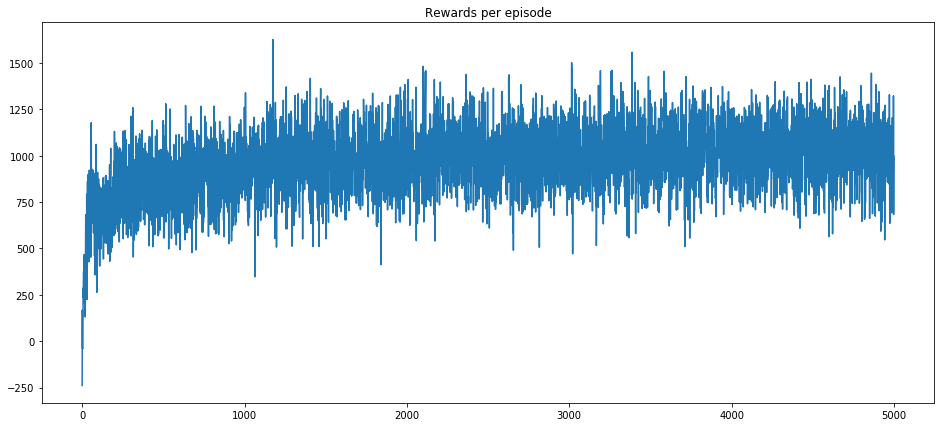

In [115]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [116]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

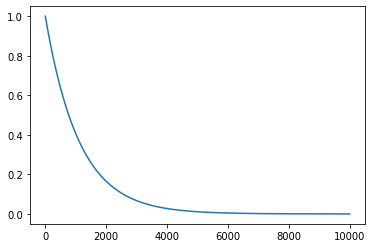

In [117]:
plt.plot(time, epsilon)
plt.show()